In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import LabelEncoder
from tqdm import tqdm

# Фиксируем "случайность" для воспроизводимости
np.random.seed(42)

# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)


## Загрузите данные: ratings.csv, books.csv, tags.csv, book_tags.csv.


In [2]:

# kagglehub.dataset_download("zygmunt/goodbooks-10k")

# # Проверим, что внутри
# for file in os.listdir(path):
#     print(file)

In [3]:
path = '.'

dtypes_books: Dict[str, str] = {
    'book_id': 'int16',
    'books_count': 'int16',
    'average_rating': 'float16',
    'ratings_count': 'int32',
    'work_ratings_count': 'int32',
    'work_text_reviews_count': 'int32',
    'ratings_1': 'int32',
    'ratings_2': 'int32',
    'ratings_3': 'int32',
    'ratings_4': 'int32',
    'ratings_5': 'int32'
}

dtypes_ratings: Dict[str, str] = {
    'book_id': 'int16',
    'user_id': 'uint16',
    'rating': 'int8'
}

# Загружаем с явным указанием типа
book_tags = pd.read_csv(path + '/book_tags.csv',
                        dtype={'goodreads_book_id': 'int16', 'tag_id': 'int16', 'count': 'int32'})
ratings = pd.read_csv(path + '/ratings.csv', dtype=dtypes_ratings)  # type: ignore
tags = pd.read_csv(path + '/tags.csv', dtype={'tag_id': 'int16', 'tag_name': 'category'})
books = pd.read_csv(path + '/books.csv', dtype=dtypes_books)  # type: ignore


# Удаляем лишнии колонки
books = books.drop(['small_image_url', 'image_url', 'isbn', 'isbn13'], axis=1)

# Документация по датасетам книг

## Обзор датасетов

| Датасет     | Назначение                   |
| ----------- | ---------------------------- |
| `books`     | Основная информация о книгах |
| `ratings`   | Рейтинги пользователей       |
| `tags`      | Теги/категории книг          |
| `book_tags` | Связь книг с тегами          |

## books - Основная информация о книгах

| Поле                        | Описание                            |
| --------------------------- | ----------------------------------- |
| `book_id`                   | Идентификатор книги в системе       |
| `best_book_id`              | Идентификатор лучшего издания книги |
| `work_id`                   | Идентификатор произведения          |
| `books_count`               | Количество изданий книги            |
| `authors`                   | Автор(ы) книги                      |
| `original_publication_year` | Год первой публикации               |
| `original_title`            | Оригинальное название               |
| `title`                     | Название на языке издания           |
| `language_code`             | Код языка издания                   |
| `average_rating`            | Средний рейтинг                     |
| `ratings_count`             | Общее количество оценок             |
| `work_ratings_count`        | Количество оценок произведения      |
| `work_text_reviews_count`   | Количество текстовых рецензий       |
| `ratings_1`                 | Количество оценок 1 звезда          |
| `ratings_2`                 | Количество оценок 2 звезды          |
| `ratings_3`                 | Количество оценок 3 звезды          |
| `ratings_4`                 | Количество оценок 4 звезды          |
| `ratings_5`                 | Количество оценок 5 звезд           |

## ratings - Оценки пользователей

| Поле      | Описание                           |
| --------- | ---------------------------------- |
| `book_id` | Идентификатор книги (внешний ключ) |
| `user_id` | Идентификатор пользователя         |
| `rating`  | Оценка (вероятно, от 1 до 5)       |

## tags - Словарь тегов

| Поле       | Описание                      |
| ---------- | ----------------------------- |
| `tag_id`   | Уникальный идентификатор тега |
| `tag_name` | Название тега/категории       |

## book_tags - Связь книг с тегами

| Поле                | Описание                                       |
| ------------------- | ---------------------------------------------- |
| `goodreads_book_id` | Идентификатор книги в Goodreads                |
| `tag_id`            | Идентификатор тега (внешний ключ)              |
| `count`             | Количество раз, которое тег был присвоен книге |


In [4]:
book_tags.info(),
ratings.info(),
tags.info(),
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int16
 1   tag_id             999912 non-null  int16
 2   count              999912 non-null  int32
dtypes: int16(2), int32(1)
memory usage: 7.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  uint16
 1   book_id  int16 
 2   rating   int8  
dtypes: int16(1), int8(1), uint16(1)
memory usage: 28.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tag_id    34252 non-null  int16   
 1   tag_name  34252 non-null  category
dtypes: category(1), int16(1)
memory usage: 468.4 KB
<class 'pa

In [5]:
# Объединяем book_tags с tags чтобы получить названия тегов
tags_with_names = book_tags.merge(tags, on='tag_id', how='left')

# Группируем по goodreads_book_id и собираем все теги в список
book_tags_grouped = tags_with_names.groupby('goodreads_book_id')['tag_name'] \
    .apply(list) \
    .reset_index(name='tags_list')

# Объединяем с исходным DataFrame
books_with_tags = books.merge(book_tags_grouped, on='goodreads_book_id', how='left')

# Объединяем книги с рейтингами
df = pd.merge(books_with_tags, ratings, on='book_id')
df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tags_list,user_id,rating
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,2886,5
1,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,6158,5
2,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,3991,4
3,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5281,5
4,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5721,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976474,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",35336,4
5976475,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",17999,3
5976476,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",49007,4
5976477,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",43319,5


In [6]:
# # Добавляем теги
df_tags = pd.merge(
    books,
    pd.merge(book_tags, tags, on='tag_id'),
    left_on='goodreads_book_id',
    right_on='goodreads_book_id'
)
df_tags

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tag_id,count,tag_name
0,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,30574,496107,to-read
1,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,11557,48220,favorites
2,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,11305,47478,fantasy
3,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,8717,44640,currently-reading
4,2,3,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,...,4800065,75867,75504,101676,455024,1156318,3011543,-32422,14984,young-adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228195,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,14612,3,history-politics
228196,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,-32731,3,world-war
228197,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,32156,3,war-ww1
228198,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,20285,3,modern-european-history


In [7]:
df

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tags_list,user_id,rating
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,2886,5
1,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,6158,5
2,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,3991,4
3,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5281,5
4,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,...,4942365,155254,66715,127936,560092,1481305,2706317,NaN,5721,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976474,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",35336,4
5976475,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",17999,3
5976476,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",49007,4
5976477,10000,8914,8914,11817,31,John Keegan,1998.0,The First World War,The First World War,NaN,...,9700,364,117,345,2031,4138,3069,"[to-read, history, currently-reading, non-fict...",43319,5


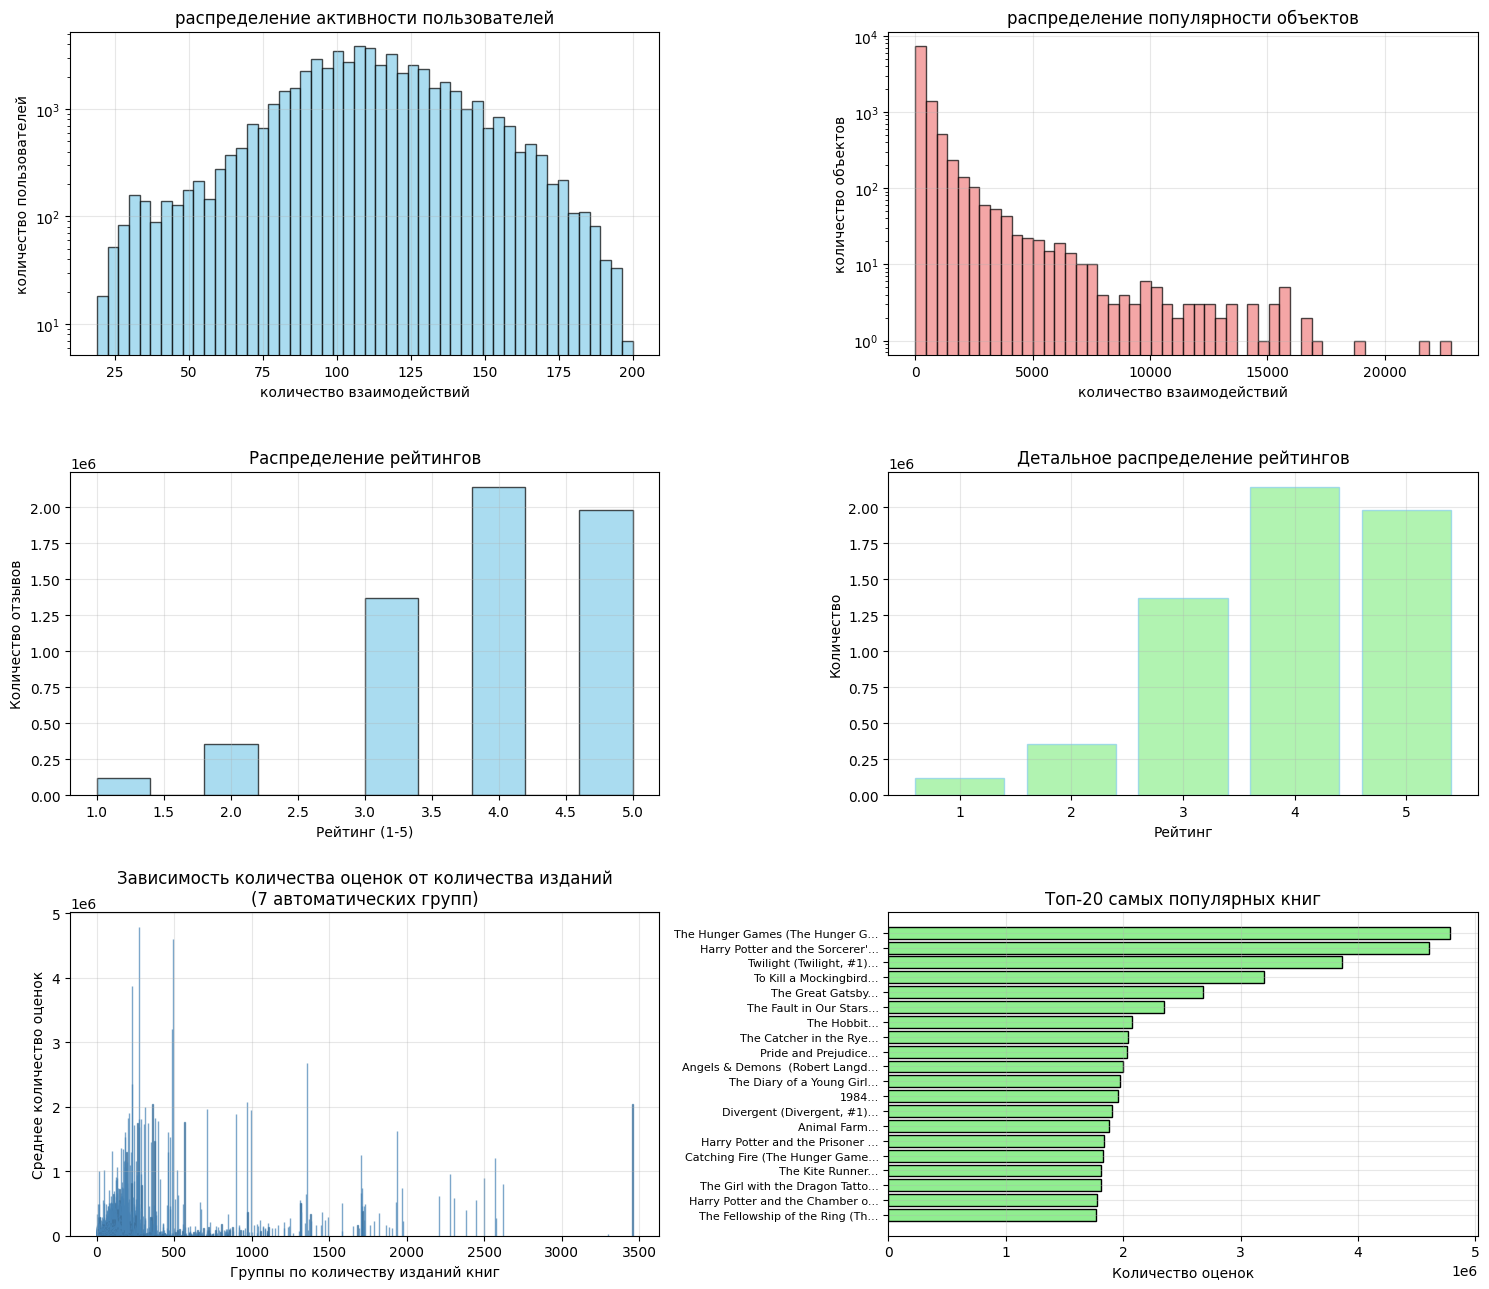

ОСНОВНАЯ СТАТИСТИКА:
уникальных пользователей: 53,424
уникальных объектов: 10,000
всего взаимодействий: 5,976,479
разреженность матрицы: 98.8813%

АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:
среднее: 111.9
медиана: 111.0
максимум: 200
пользователей с 1 взаимодействием: 0

ПОПУЛЯРНОСТЬ ОБЪЕКТОВ:
среднее: 597.6
медиана: 248.0
максимум: 22806
объектов с 1 взаимодействием: 0

РЕЙТИНГ ОБЪЕКТОВ:
Средний рейтинг: 3.92
Медианный рейтинг: 4.00
Стандартное отклонение: 0.99

КОЛИЧЕСТВО ОЦЕНОК:
Среднее: 365624.8
Медианное: 103915.0
Максимальное: 4780653
Минимальное: 2716


In [8]:
# базовая статистика
n_users = df['user_id'].nunique()
n_book = df['book_id'].nunique()
n_interactions = len(df)
sparsity = 1 - (n_interactions / (n_users * n_book))


# анализ активности
user_activity = df.groupby('user_id').size()
item_books = df.groupby('book_id').size()

# визуализация
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 13))

# распределение активности пользователей
ax1.hist(user_activity, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('количество взаимодействий')
ax1.set_ylabel('количество пользователей')
ax1.set_title('распределение активности пользователей')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# распределение популярности объектов
ax2.hist(item_books, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('количество взаимодействий')
ax2.set_ylabel('количество объектов')
ax2.set_title('распределение популярности объектов')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)


ax3.hist(df['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('Рейтинг (1-5)')
ax3.set_ylabel('Количество отзывов')
ax3.set_title('Распределение рейтингов')
ax3.grid(True, alpha=0.3)

# детальное распределение рейтингов
rating_stats = df['rating'].value_counts().sort_index()
ax4.bar(rating_stats.index, rating_stats.values, alpha=0.7, color='lightgreen', edgecolor='skyblue')
ax4.set_xlabel('Рейтинг')
ax4.set_ylabel('Количество')
ax4.set_title('Детальное распределение рейтингов')
ax4.grid(True, alpha=0.3)

# Группируем по book_id чтобы убрать дубликаты
df_books = df.drop_duplicates(subset=['book_id'])

ax5.bar(df_books['books_count'], df_books['ratings_count'], color='black', alpha=0.7, edgecolor='steelblue')
ax5.set_xlabel('Группы по количеству изданий книг')
ax5.set_ylabel('Среднее количество оценок')
ax5.set_title('Зависимость количества оценок от количества изданий\n(7 автоматических групп)')
ax5.grid(True, alpha=0.3)


# Топ-20 самых популярных книг
top_popular = df_books.nlargest(20, 'ratings_count')[['title', 'ratings_count']]
ax6.barh(range(len(top_popular)), top_popular['ratings_count'], color='lightgreen', edgecolor='black')
ax6.set_yticks(range(len(top_popular)))
ax6.set_yticklabels([title[:30] + '...' for title in top_popular['title']], fontsize=8)
ax6.set_title('Топ-20 самых популярных книг')
ax6.set_xlabel('Количество оценок')
ax6.grid(True, alpha=0.3)
ax6.invert_yaxis()


plt.tight_layout()
plt.show()

print("ОСНОВНАЯ СТАТИСТИКА:")
print(f"уникальных пользователей: {n_users:,}")
print(f"уникальных объектов: {n_book:,}")
print(f"всего взаимодействий: {n_interactions:,}")
print(f"разреженность матрицы: {sparsity:.4%}")

print(f"\nАКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:")
print(f"среднее: {user_activity.mean():.1f}")
print(f"медиана: {user_activity.median():.1f}")
print(f"максимум: {user_activity.max()}")
print(f"пользователей с 1 взаимодействием: {(user_activity == 1).sum():,}")

print(f"\nПОПУЛЯРНОСТЬ ОБЪЕКТОВ:")
print(f"среднее: {item_books.mean():.1f}")
print(f"медиана: {item_books.median():.1f}")
print(f"максимум: {item_books.max()}")
print(f"объектов с 1 взаимодействием: {(item_books == 1).sum():,}")

print(f"\nРЕЙТИНГ ОБЪЕКТОВ:")
print(f"Средний рейтинг: {df['rating'].mean():.2f}")
print(f"Медианный рейтинг: {df['rating'].median():.2f}")
print(f"Стандартное отклонение: {df['rating'].std():.2f}")

print(f"\nКОЛИЧЕСТВО ОЦЕНОК:")
print(f"Среднее: {df['ratings_count'].mean():.1f}")
print(f"Медианное: {df['ratings_count'].median():.1f}")
print(f"Максимальное: {df['ratings_count'].max():.0f}")
print(f"Минимальное: {df['ratings_count'].min():.0f}")

## Анализ данных системы рекомендаций

### **Масштаб и охват системы**

- **Обширная пользовательская база**: 53,424 уникальных пользователя взаимодействуют с 10,000 объектами
- **Высокая активность**: 5.98 миллионов взаимодействий свидетельствуют о живом и активном сообществе
- **Экспоненциальное распределение популярности**: максимальное количество взаимодействий с объектом (22,806) значительно превышает медианное (248)

### **Поведенческие паттерны пользователей**

- **Однородная активность**: медиана взаимодействий (111) близка к среднему (111.9), что указывает на равномерное распределение активности

### **Характеристики контента**

- **Высокое качество контента**: средний рейтинг 3.92 из 5 указывает на общее удовлетворение пользователей
- **Консистентность оценок**: низкое стандартное отклонение (0.99) означает согласованность мнений пользователей
- **Длинный хвост популярности**: разница между медианной (248) и средней (597.6) популярностью показывает наличие небольшого количества очень популярных объектов

### **Выводы для рекомендательной системы**

1. **Высокая разреженность данных** (98.88%) требует применения методов коллаборативной фильтрации, устойчивых к разреженным матрицам
2. **Равномерное распределение активности** позволяет использовать традиционные алгоритмы без специальной обработки аномалий
3. **Качественный контент** упрощает задачу рекомендаций, так как пользователи в целом довольны предлагаемыми объектами


## Визуализируйте самые частые теги для книг (на основе book_tags.csv).


In [9]:
def clean_tags(tag_name):
    """Очистка тегов: оставляем только английские буквы, цифры и годы"""

    # Проверяем, что есть хотя бы одна английская буква
    if not re.search(r'[a-zA-Z]', str(tag_name)):
        return None

    # Удаляем все символы, кроме английских букв, цифр, дефиса и пробела
    cleaned = re.sub(r'[^a-zA-Z0-9\s-]', '', str(tag_name))

    # Удаляем лишние пробелы
    cleaned = cleaned.strip()

    # Проверяем, что осталось что-то осмысленное (не пустая строка и не только цифры)
    if not cleaned or cleaned.replace('-', '').isdigit():
        return None

    return cleaned

Количество тегов после очистки: 205741
Уникальных очищенных тегов: 12625


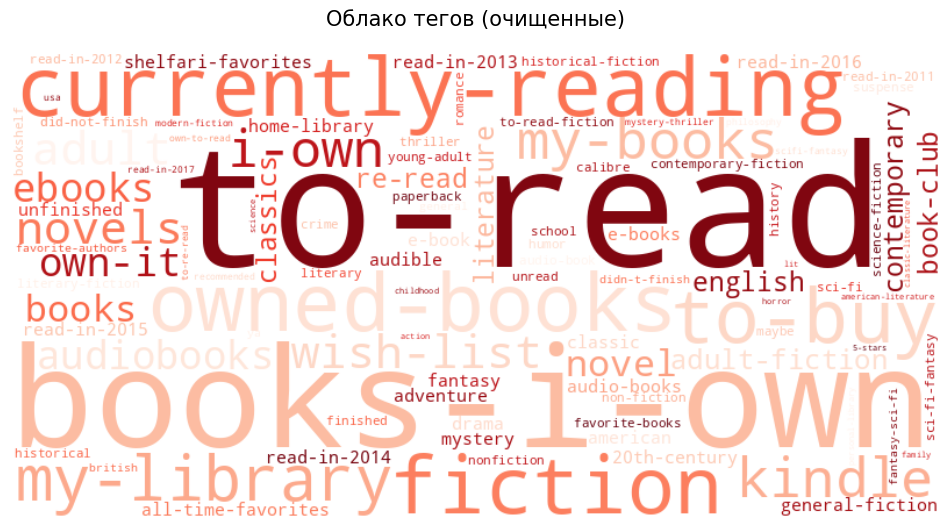


Топ-20 тегов:
cleaned_tag
to-read              2281
books-i-own          2243
currently-reading    2237
owned-books          2192
fiction              2114
to-buy               2046
my-library           1999
my-books             1939
kindle               1898
i-own                1731
wish-list            1672
novels               1654
adult                1639
audiobooks           1552
own-it               1548
ebooks               1530
novel                1335
books                1305
adult-fiction        1293
contemporary         1187
Name: count, dtype: int64


In [10]:
# Очищаем теги и создаем новую колонку
df_tags['cleaned_tag'] = df_tags['tag_name'].apply(clean_tags)

# Удаляем теги, которые стали None после очистки
df_tags = df_tags[df_tags['cleaned_tag'].notna()]

# Обновляем стоп-теги (используем очищенные версии)
stop_tags = {
    'owned', 'favorites', 'currentlyreading', 'series', 'booksiown',
    'to', 'default', 'ebook', 'audiobook', 'audio', 'library', 'bookclub',
    'favourites', 'tobuy', 'mylibrary', 'wishlist', 'iown', 'wishlist',
    'ownit', 'reread', 'abandoned', 'shelfarifavorites', 'have',
    'homelibrary', 'borrowed', 'favorite'
}

# Фильтруем теги по очищенным названиям
df_tags = df_tags[~df_tags['cleaned_tag'].isin(stop_tags)]

# Подсчитываем частотность ОЧИЩЕННЫХ тегов
tag_counts = df_tags['cleaned_tag'].value_counts()

print(f"Количество тегов после очистки: {len(df_tags)}")
print(f"Уникальных очищенных тегов: {len(tag_counts)}")

# Настраиваем облако слов
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
)

# Генерируем облако слов с учетом весов ОЧИЩЕННЫХ тегов
wordcloud = wc.generate_from_frequencies(tag_counts)

# Визуализируем
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако тегов (очищенные)', pad=20, size=15)
plt.show()

# Показываем топ-20 тегов
print("\nТоп-20 тегов:")
print(tag_counts.head(20))

Для построения качественной модели, которая будет определять смысловую близость книг по тегам, необходимо предварительно очистить данные. Нужно удалить служебные теги (например, to-read, to-buy), которые не несут информации о содержании


# Этап 2: базовые и контентные модели


## Top-20 самых популярных книг


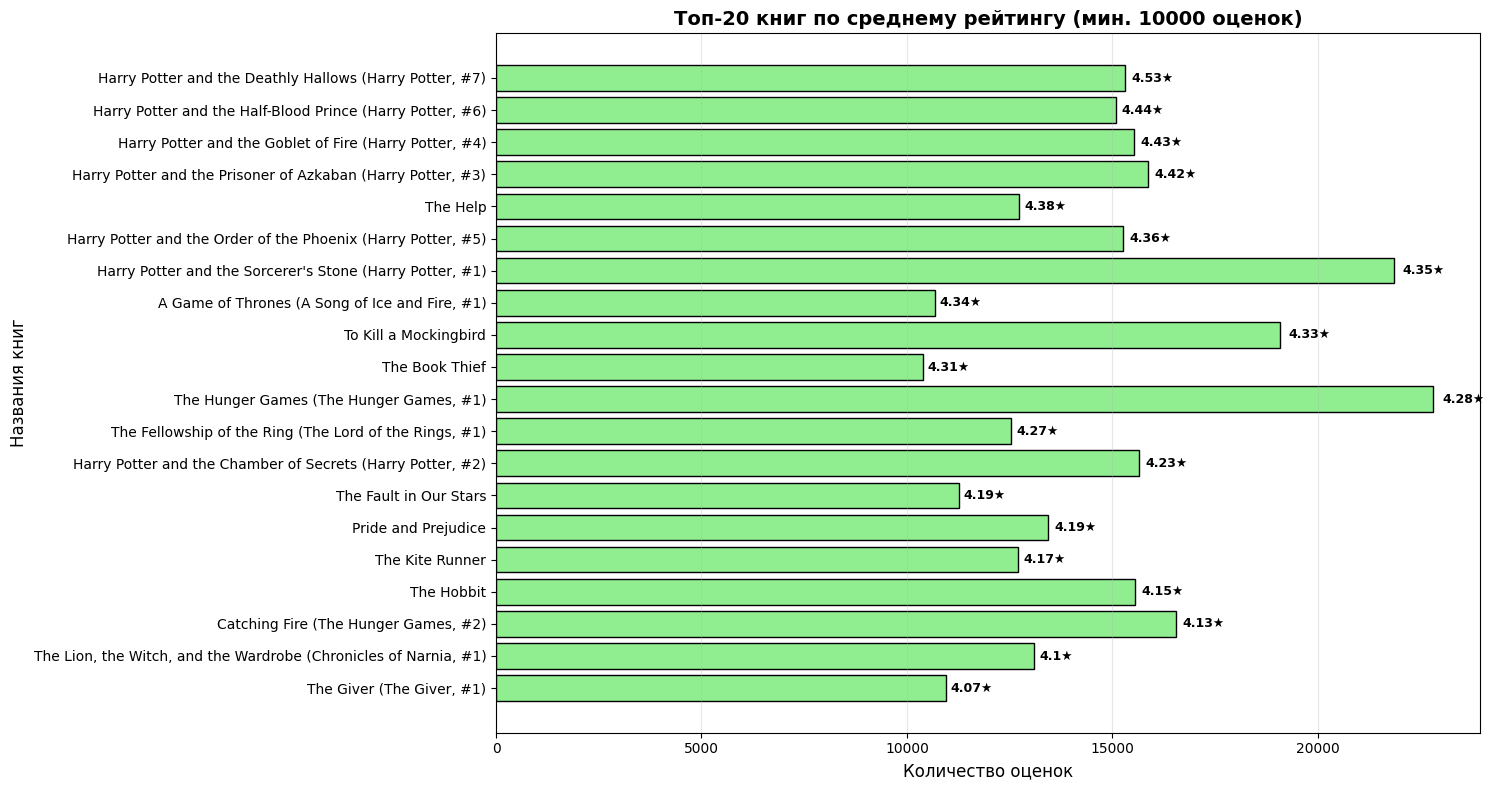

In [11]:
top_books = (df.groupby('book_id')['rating']
             .agg(avg_rating='mean', ratings_count='count')
             .reset_index()
             .query('ratings_count >= 10000')
             .assign(avg_rating=lambda x: x['avg_rating'].round(2))
             .merge(df[['book_id', 'title', 'authors']].drop_duplicates(), on='book_id')
             .sort_values('avg_rating', ascending=False)
             .head(20)
             [['book_id', 'title', 'authors', 'avg_rating', 'ratings_count']])

fig, ax = plt.subplots(figsize=(15, 8))


ax.barh(range(len(top_books)), top_books['ratings_count'], color='lightgreen', edgecolor='black')

ax.set_yticks(range(len(top_books)))
ax.set_yticklabels(top_books['title'], fontsize=10)

ax.set_title('Топ-20 книг по среднему рейтингу (мин. 10000 оценок)', fontsize=14, fontweight='bold')
ax.set_xlabel('Количество оценок', fontsize=12)
ax.set_ylabel('Названия книг', fontsize=12)

ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Добавляем значения рейтингов на график
for i, (rating, count) in enumerate(zip(top_books['avg_rating'], top_books['ratings_count'])):
    ax.text(count + count*0.01, i, f'{rating}★', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Контентная модель


In [12]:
def simple_medical_text_preprocessing(text):

    if pd.isna(text):
        return ""

    text = text.lower()

    # базовая очистка - сохраняем апострофы для английских сокращений
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)

    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    #  токенизация через split (вместо word_tokenize)
    tokens = text.split()

    stopwords = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        'this', 'that', 'these', 'those', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may',
        'might', 'must', 'can', 'it', 'its', 'they', 'them', 'their', 'i', 'me', 'my', 'we', 'our'
    }

    tokens = [token for token in tokens if token not in stopwords]

    # простая лемматизация через базовые правила (вместо WordNetLemmatizer)
    def simple_lemmatize(token):
        if token.endswith('ing'):
            return token[:-3]
        elif token.endswith('ed'):
            return token[:-2]
        elif token.endswith('s'):
            return token[:-1]
        return token

    tokens = [simple_lemmatize(token) for token in tokens]

    return ' '.join(tokens)


books_list = (df[['book_id', 'authors', 'tags_list', 'original_title']]
              .drop_duplicates(subset=['book_id'])
              # Для избежания пустот удаляем записи где нет не названия не тега
              .loc[lambda x: x['original_title'].notna() | x['tags_list'].notna()]
              .reset_index(drop=True))

# Преобразуем список тегов в строку и создаем профили
books_list['tags_str'] = books_list['tags_list'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
books_list['book_profile'] = books_list['original_title'].apply(
    simple_medical_text_preprocessing) + ' ' + books_list['tags_str'].apply(simple_medical_text_preprocessing)


# Создаем TF-IDF только при первом вызове (кешировать на практике)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(books_list['book_profile'])


def get_similar_books(book_id, N=5):
    nn_model = NearestNeighbors(n_neighbors=N+1, metric='cosine', algorithm='brute')
    nn_model.fit(tfidf_matrix)

    idx = books_list[books_list['book_id'] == book_id].index[0]
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx])

    # Убираем первый результат (сама книга)
    indices = indices[0][1:]
    distances = distances[0][1:]

    similarities = 1 - distances
    result = books_list.iloc[indices].copy()
    result['similarity_score'] = similarities

    return result


# Пример использования
similar_books = get_similar_books(8427, 5)
similar_books[['book_id', 'original_title', 'authors', 'similarity_score']]

,book_id,original_title,authors,similarity_score
4745,4888,Garden of Shadows,V.C. Andrews,0.749380
5757,5952,The Bone Garden,Tess Gerritsen,0.743684
1502,1528,Gardens of the Moon,Steven Erikson,0.731485
1383,1406,Winter Garden,Kristin Hannah,0.715918
5313,5479,The Rose Garden,Susanna Kearsley,0.708984


**Вывод:**

Система показывает хорошие результаты для прямых совпадений, но для сложных случаев нужно больше данных или более сложная обработка.


# Визуализация схожести данных в двумерном пространстве для понимания структуры данных


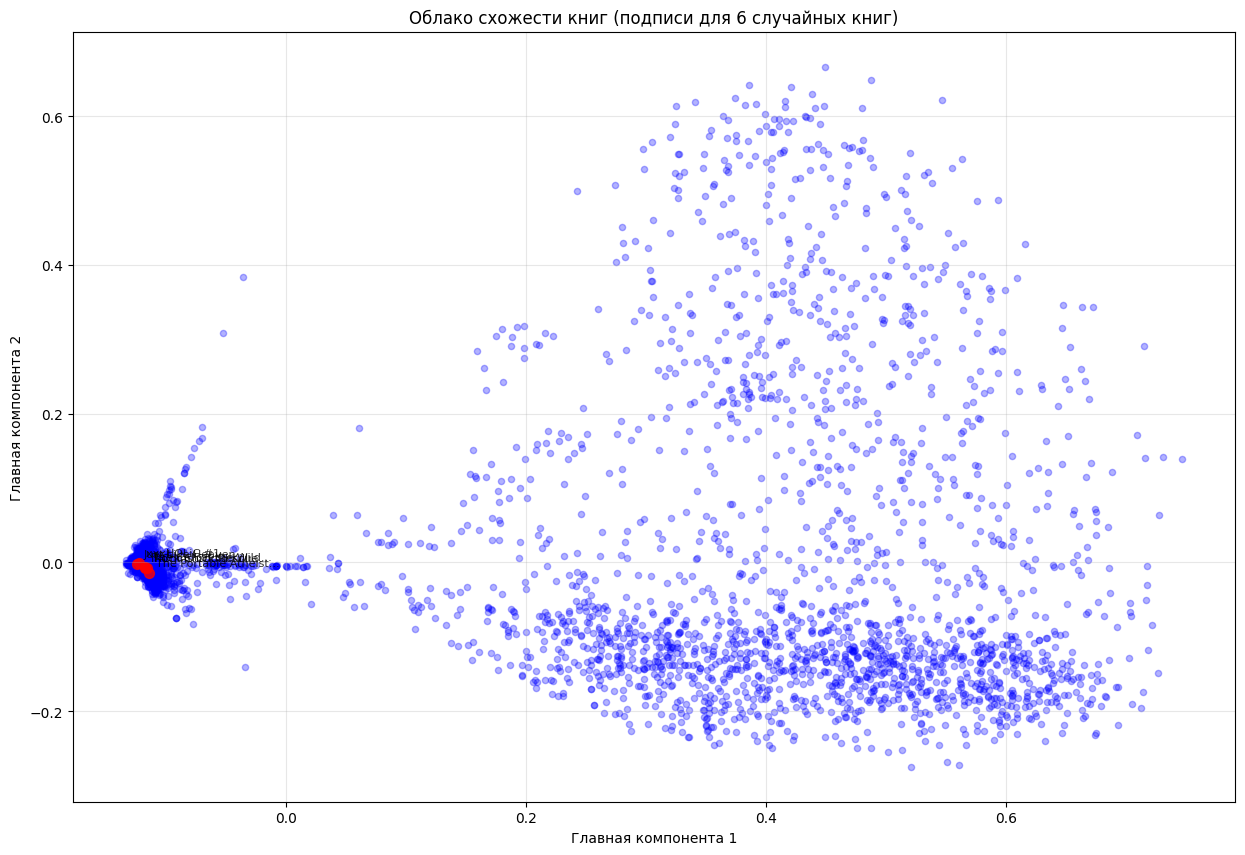

In [13]:
def create_books_cloud_with_labels(sample_size=10):
    # Берем случайную выборку книг для подписей
    sample_indices = np.random.choice(len(books_list), size=sample_size, replace=False)

    # Уменьшаем размерность
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(tfidf_matrix.toarray())

    plt.figure(figsize=(15, 10))

    # Все точки
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.3, s=20, color='blue')

    # Точки с подписями
    plt.scatter(vectors_2d[sample_indices, 0], vectors_2d[sample_indices, 1],
                alpha=0.8, s=50, color='red')

    # Добавляем подписи
    for idx in sample_indices:
        title = books_list.iloc[idx]['original_title']
        short_title = title[:20] + '...' if len(title) > 20 else title
        plt.annotate(short_title,
                     (vectors_2d[idx, 0], vectors_2d[idx, 1]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=8, alpha=0.8)

    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title(f'Облако схожести книг (подписи для {sample_size} случайных книг)')
    plt.grid(True, alpha=0.3)
    plt.show()


create_books_cloud_with_labels(6)

Судя по данным, явно выделяется отдельная группа тегов, связанных с книгами. Скорее всего, эта группа содержит не так много информации о содержании книг, а представляет собой пользовательские метки: прочитана ли книга, когда была прочитана и т.д. Хотя эти данные напрямую не характеризуют книгу, для оценки похожести пользовательских предпочтений эта информация вполне релевантна и на текущем этапе остается в датасете


# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)


In [14]:
# Создаем матрицу оценок (пользователь x книга)
def create_interaction_matrix(weights, name, df):
    """Создает матрицу пользователь - элемент"""
    users = df['user_id'].unique()
    books = df['book_id'].unique()

    # Создаем mapping
    user_to_idx = {user: idx for idx, user in enumerate(users)}
    book_to_idx = {book: idx for idx, book in enumerate(books)}

    row_indices = df['user_id'].map(user_to_idx)
    col_indices = df['book_id'].map(book_to_idx)

    matrix = csr_matrix((weights, (row_indices, col_indices)), shape=(len(user_to_idx), len(book_to_idx)))

    print(
        f"   Матрица '{name}': {matrix.shape[0]} пользователей - {matrix.shape[1]} элементов средний рейтинг {weights.mean():.2f}")

    return matrix, user_to_idx, book_to_idx


df_not_none_title = df[df['original_title'].str.len() > 1]
# различные варианты матриц
matrix_explicit, user_map, book_map = create_interaction_matrix(
    df_not_none_title['rating'],
    "Явные признаки",
    df_not_none_title
)

matrix_implicit, _, _ = create_interaction_matrix(
    (df_not_none_title['rating'] >= 4).astype(int),
    "Неявные признаки",
    df_not_none_title
)

   Матрица 'Явные признаки': 53424 пользователей - 9409 элементов средний рейтинг 3.92
   Матрица 'Неявные признаки': 53424 пользователей - 9409 элементов средний рейтинг 0.69


In [15]:
def predict_rating(user_id, book_id, k=5, method='explicit'):
    """Предсказание оценки через K наиболее похожих книг"""

    # Находим индекс пользователя и книги
    user_idx = user_map[user_id]
    book_idx = book_map[book_id]

    # Выбираем матрицу в зависимости от метода
    if method == 'explicit':
        interaction_matrix = matrix_explicit
        matrix_name = "явным признакам (оценки)"
    elif method == 'implicit':
        interaction_matrix = matrix_implicit
        matrix_name = "неявным признакам (лайки)"
    else:
        raise ValueError("Метод должен быть 'explicit' или 'implicit'")

    # Рассчитываем матрицу схожестей
    cosine_sim_books = cosine_similarity(interaction_matrix.T, interaction_matrix.T)
    book_similarities = cosine_sim_books[book_idx]
    similar_books_idx = np.argsort(book_similarities)[-k-1:-1][::-1]
    idx_to_book = {idx: book_id for book_id, idx in book_map.items()}
    similar_books_ids = [idx_to_book[idx] for idx in similar_books_idx]

    # Получаем взаимодействия пользователя для похожих книг
    user_interactions = interaction_matrix[user_idx].toarray().flatten()
    similar_interactions = user_interactions[similar_books_idx]

    # Усредняем взаимодействия
    valid_mask = similar_interactions > 0 if method == 'explicit' else slice(None)
    valid_interactions = similar_interactions[valid_mask]
    valid_books_ids = similar_books_ids[:len(valid_interactions)]

    if len(valid_interactions) == 0:
        return None, [], [], similar_books_ids, matrix_name

    return np.mean(valid_interactions), valid_interactions, valid_books_ids, similar_books_ids, matrix_name


# Пример использования для обоих методов
user_id = list(user_map.keys())[51]
book_id = list(book_map.keys())[51]

print("=" * 60)
print("СРАВНЕНИЕ ПОДХОДОВ В ОДНОЙ ФУНКЦИИ:")
print("=" * 60)

# Предсказания для обоих методов
results = {}
for method in ['explicit', 'implicit']:
    pred_score, interactions, used_books, all_books, matrix_name = predict_rating(user_id, book_id, k=5, method=method)
    results[method] = {
        'prediction': pred_score,
        'interactions': interactions,
        'used_books': used_books,
        'all_books': [books[books['book_id'] == i]['original_title'].iloc[0] for i in all_books],
        'name': matrix_name
    }

# Вывод результатов
for method, result in results.items():
    print(f"\n{result['name'].upper()}:")
    print(f"Книга: {books[books['book_id'] == book_id]['original_title'].iloc[0]}")
    print(f"Предсказание: {result['prediction']:.2f}")
    print(f"Все похожие книги: {result['all_books']}")
    print(f"Использовано для предсказания: {result['used_books']}")
    print(f"Взаимодействия: {result['interactions']}")

print(f"\nРазница в предсказаниях: {abs(results['explicit']['prediction'] - results['implicit']['prediction']):.2f}")

СРАВНЕНИЕ ПОДХОДОВ В ОДНОЙ ФУНКЦИИ:

ЯВНЫМ ПРИЗНАКАМ (ОЦЕНКИ):
Книга: Eclipse
Предсказание: 4.80
Все похожие книги: ['New Moon (Twilight, #2)', 'Breaking Dawn', 'Twilight', 'Catching Fire', 'Mockingjay']
Использовано для предсказания: [np.int16(49), np.int16(56), np.int16(3), np.int16(17), np.int16(20)]
Взаимодействия: [4 5 5 5 5]

НЕЯВНЫМ ПРИЗНАКАМ (ЛАЙКИ):
Книга: Eclipse
Предсказание: 1.00
Все похожие книги: ['New Moon (Twilight, #2)', 'Breaking Dawn', 'Twilight', 'Catching Fire', 'Mockingjay']
Использовано для предсказания: [np.int16(49), np.int16(56), np.int16(3), np.int16(17), np.int16(20)]
Взаимодействия: [1 1 1 1 1]

Разница в предсказаниях: 3.80


Оба метода успешно нашли релевантные похожие книги из вселенной "Сумерек" и "Голодных игр", что демонстрирует корректную работу алгоритма схожести. Разница в предсказаниях (4.80 против 1.00) ожидаема и объясняется разной природой метрик: явный метод предсказывает среднюю оценку 4.80 на основе реальных оценок пользователя [4, 5, 5, 5, 5], тогда как неявный метод предсказывает вероятность лайка 1.00, поскольку все оценки ≥4 были преобразованы в лайки [1, 1, 1, 1, 1]


Вычислительная сложность текущего подхода составляет O(n²) из-за попарного расчета матрицы схожестей между всеми книгами, что делает его непрактичным для больших данных — при миллионе книг потребуется триллион операций. Для оптимизации следует перейти от точных вычислений к приближенным методам: использовать алгоритмы ближайших соседей с деревьями или HNSW (сложность O(n log n)), мини-батчную обработку, локальные вычисления только внутри релевантных категорий книг, а для продакшн-среды — векторные базы данных вроде Tarantool, которые обеспечивают быстрый поиск соседей за O(log n) с минимальными затратами памяти.


# Этап 4: матричные разложения (Matrix Factorization)


In [16]:
# функция для подготовки разреженной матрицы рейтингов
def prepare_matrix(ratings_df):
    # Создаем маппинг ID -> индекс
    user_to_idx = {user_id: idx for idx, user_id in enumerate(ratings_df['user_id'].unique())}
    book_to_idx = {book_id: idx for idx, book_id in enumerate(ratings_df['book_id'].unique())}

    # Обратные маппинги
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_book = {idx: book_id for book_id, idx in book_to_idx.items()}

    # Преобразуем ID в индексы
    user_indices = ratings_df['user_id'].map(user_to_idx)
    book_indices = ratings_df['book_id'].map(book_to_idx)

    matrix = csr_matrix((ratings_df['rating'].astype(np.float64), (user_indices, book_indices)),
                        shape=(len(user_to_idx), len(book_to_idx)), dtype=np.float64)

    return matrix, idx_to_user, idx_to_book

In [17]:
# делим выборку на обучение и тест
train, test = train_test_split(df_not_none_title, test_size=0.2, random_state=42, stratify=df_not_none_title['user_id'])
train_mat, idx_to_user, idx_to_book = prepare_matrix(train)
test_mat, _, _ = prepare_matrix(test)

In [18]:
# функция для расчета RMSE по известным тестовым оценкам
def calculate_rmse(pred, actual_mat):
    test_users, test_items = actual_mat.nonzero()
    return np.sqrt(mean_squared_error(actual_mat[test_users, test_items].A1, pred[test_users, test_items]))

In [19]:
def find_best_svd_params(train_mat, test_mat, k_values=list(range(18, 22))):
    """Подбор оптимального k для SVD"""

    best_rmse = float('inf')
    best_k = k_values[0]

    for k in k_values:
        print(f"Пробуем k={k}...")

        U, sigma, Vt = svds(train_mat, k=k)
        Sigma = np.diag(sigma)
        pred = np.dot(np.dot(U, Sigma), Vt)
        pred = np.clip(pred, 0, 1)

        # Вычисляем RMSE на тестовых данных
        rmse = calculate_rmse(pred, test_mat)

        print(f"k={k}, RMSE={rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k

    print(f"\nЛучший параметр: k={best_k}, RMSE={best_rmse:.4f}")
    return best_k, best_rmse


# Использование
print("Подбор оптимальных параметров для SVD...")
best_k, _ = find_best_svd_params(train_mat, test_mat)

Подбор оптимальных параметров для SVD...
Пробуем k=18...
k=18, RMSE=3.9694
Пробуем k=19...
k=19, RMSE=3.9693
Пробуем k=20...
k=20, RMSE=3.9694
Пробуем k=21...
k=21, RMSE=3.9695

Лучший параметр: k=19, RMSE=3.9693


In [20]:
# SVD через sklearn
print("Вычисление SVD через sklearn...")
svd_sklearn = TruncatedSVD(n_components=19, random_state=42, algorithm='arpack')
U_sklearn = svd_sklearn.fit_transform(train_mat)
Sigma_sklearn = np.diag(svd_sklearn.singular_values_)
Vt_sklearn = svd_sklearn.components_
sklearn_pred = np.dot(U_sklearn, Vt_sklearn)

Вычисление SVD через sklearn...


Первоначально использовались оба метода: `svds` и `TruncatedSVD`.
После приведения вычислений к единому формату результаты стали практически идентичными.
Однако `TruncatedSVD` работает почти в два раза быстрее (2.9 секунд против 4.3 секунд у `svds`),
поэтому для финальной реализации был выбран только `TruncatedSVD`.


In [21]:
# функция для расчета Precision@K и Recall@K (по топ-K рекомендациям на тесте)
def precision_recall_at_k(pred, test, k=5, threshold=4.0):
    n_users = pred.shape[0]
    precisions, recalls, ndcg_at_k = [], [], []

    for user in range(n_users):
        # берем оригинальные айтемы пользователя в тесте, которые он действительно оценил >= threshold
        relevant_test_items = test[user].indices[test[user].data >= threshold]

        if len(relevant_test_items) == 0:
            continue   # пропускаем пользователей, у которых в тесте нет релевантных по нашему threshold

         # топ-K рекомендаций для пользователя
        top_k_items = np.argsort(- pred[user])[:k]
        # из рекомендованных считаем, сколько действительно релевантных
        n_relevant_and_recommended = len(set(top_k_items) & set(relevant_test_items))
        precisions.append(n_relevant_and_recommended / k)
        recalls.append(n_relevant_and_recommended / len(relevant_test_items))

        # Расчет NDCG@K
        relevance = [1 if item in set(relevant_test_items) else 0 for item in top_k_items]
        if sum(relevance) > 0:
            ideal = sorted(relevance, reverse=True)
            dcg = sum(r / np.log2(i + 2) for i, r in enumerate(relevance))
            idcg = sum(r / np.log2(i + 2) for i, r in enumerate(ideal))
            ndcg = dcg / idcg
        else:
            ndcg = 0
        ndcg_at_k.append(ndcg)

    return np.mean(precisions), np.mean(recalls), np.mean(ndcg_at_k)

В качестве релевантных items считайте книги, которым пользователь поставил оценку выше порога (например, ≥ 4).


In [22]:
# оцениваем RMSE
sklearn_rmse = calculate_rmse(sklearn_pred, test_mat)

# оцениваем Precision@K, Recall@K, NDCG@K (top-5, threshold 3.5)
prec_sklearn, rec_sklearn, ndcg_sklearn = precision_recall_at_k(sklearn_pred, test_mat, k=5, threshold=3.5)

In [23]:
def get_recommendations(user_id, pred_matrix, N=5):
    # Находим индекс пользователя
    user_idx = list(idx_to_user.values()).index(user_id)

    # Берем предсказания для пользователя
    user_predictions = pred_matrix[user_idx]

    # Создаем mapping book_id -> index матрицы
    book_to_idx = {book_id: idx for idx, book_id in idx_to_book.items()}

    # Находим индексы прочитанных книг
    user_read_books = train[train['user_id'] == user_id]['book_id'].values
    read_indices = [book_to_idx[book_id] for book_id in user_read_books if book_id in book_to_idx]

    # Создаем копию предсказаний и зануляем прочитанные
    filtered_predictions = user_predictions.copy()
    filtered_predictions[read_indices] = -np.inf  # делаем очень низкий рейтинг

    # Получаем топ-N среди оставшихся
    top_n_items = np.argsort(-filtered_predictions)[:N]

    return [{
        'book_id': idx_to_book[idx],
        'book_title': books[books['book_id'] == idx_to_book[idx]]['original_title'].iloc[0],
        'predicted_rating': user_predictions[idx],
        'rank': i + 1
    } for i, idx in enumerate(top_n_items)]


target_user_id = train['user_id'].iloc[51]
train[train['user_id'] == target_user_id]

user_id = train['user_id'].iloc[51]  # берем пользователя из данных
recommendations = get_recommendations(user_id, sklearn_pred)
pd.DataFrame(recommendations)

,book_id,book_title,predicted_rating,rank
0,19,The Fellowship of the Ring,2.780207,1
1,37,"The Lion, the Witch and the Wardrobe",2.538252,2
2,13,Nineteen Eighty-Four,2.091031,3
3,62,Northern Lights,1.819610,4
4,14,Animal Farm: A Fairy Story,1.679632,5


In [24]:
target_user_id = train['user_id'].iloc[51]
user_books = train[train['user_id'] == target_user_id]

# Уникальные книги с основной информацией
unique_books = user_books[['original_title', 'authors', 'original_publication_year']].drop_duplicates()
unique_books

,original_title,authors,original_publication_year
948285,The Secret Garden,Frances Hodgson Burnett,1911.0
4834508,ヘルシング 1,"Kohta Hirano, Duane Johnson",1998.0
500420,The Giver,Lois Lowry,1993.0
5738323,デスノート #8 (Desu Nōto) Mato (的),"Tsugumi Ohba, Takeshi Obata",2005.0
1794382,Good Omens: The Nice and Accurate Prophecies o...,"Terry Pratchett, Neil Gaiman",1990.0
...,...,...,...
753130,Wuthering Heights,"Emily Brontë, Richard J. Dunn",1847.0
4884904,"Astonishing X-Men, Volume 1: Gifted","Joss Whedon, John Cassaday",2004.0
5676205,Ozma of Oz,L. Frank Baum,1907.0
1008301,Le Comte de Monte-Cristo,"Alexandre Dumas, Robin Buss",1844.0


Предложенные книги — это отличные рекомендации. Все пять позиций идеально соответствуют вкусу пользователя: это популярные фэнтези-серии для подростков о магии, приключениях и необычных мирах, которые продолжают его интерес к таким работам, как «Гарри Поттер» и «Артемис Фаул».


# Этап 5: оценка и сравнение моделей


In [25]:
print(f"\nОценка качества:")
print(f"RMSE: {sklearn_rmse:.4f}")
print(f"Precision@5: {prec_sklearn:.4f}")
print(f"Recall@5: {rec_sklearn:.4f}")
print(f"NDCG@5: {ndcg_sklearn:.4f}")


Оценка качества:
RMSE: 3.9733
Precision@5: 0.0094
Recall@5: 0.0032
NDCG@5: 0.0287


Было до начала улучшения

- Precision@5 (numpy/svds): 0.0055
- Recall@5 (numpy/svds): 0.0018
- NDCG@5 (numpy/svds): 0.0159


In [26]:
item_popularity = np.array(train_mat.sum(axis=0)).flatten()


def calculate_coverage(pred_matrix, top_k=10):
    """Какая доля книг получает рекомендации"""
    n_users, n_items = pred_matrix.shape
    recommended_items = set()
    for user in range(n_users):
        top_items = np.argsort(-pred_matrix[user])[:top_k]
        recommended_items.update(top_items)
    return len(recommended_items) / n_items


def popularity_bias(pred_matrix, item_popularity, top_k=10):
    """Насколько рекомендации смещены к популярным книгам"""
    n_users = pred_matrix.shape[0]
    popularity_scores = []
    for user in range(n_users):
        top_items = np.argsort(-pred_matrix[user])[:top_k]
        # Используем логарифм, чтобы сгладить распределение
        avg_popularity = np.mean(np.log1p([item_popularity[item] for item in top_items]))
        popularity_scores.append(avg_popularity)
    return np.mean(popularity_scores)


def personalization_score(pred_matrix, top_k=10, sample_users=1000):
    """Насколько рекомендации различаются у разных пользователей"""
    n_users = min(pred_matrix.shape[0], sample_users)
    user_recommendations = []
    for user in range(n_users):
        top_items = set(np.argsort(-pred_matrix[user])[:top_k])
        user_recommendations.append(top_items)

    similarities = []
    for i in range(n_users):
        for j in range(i+1, n_users):
            intersection = len(user_recommendations[i] & user_recommendations[j])
            union = len(user_recommendations[i] | user_recommendations[j])
            if union > 0:
                similarities.append(intersection / union)

    return 1 - np.mean(similarities) if similarities else 0


def novelty_score(pred_matrix, item_popularity, top_k=10):
    """Насколько рекомендации содержат непопулярные/редкие книги"""
    n_users = pred_matrix.shape[0]
    novelty_scores = []
    for user in range(n_users):
        top_items = np.argsort(-pred_matrix[user])[:top_k]
        # Используем обратный логарифмированный ранг
        avg_novelty = np.mean([1/np.log1p(item_popularity[item] + 1) for item in top_items])
        novelty_scores.append(avg_novelty)
    return np.mean(novelty_scores)


def hit_rate(pred_matrix, test_mat, top_k=10):
    """Доля пользователей, которым попала хотя бы одна релевантная рекомендация"""
    n_users = pred_matrix.shape[0]
    hits = 0
    for user in range(n_users):
        relevant_items = test_mat[user].indices[test_mat[user].data >= 4]
        if len(relevant_items) > 0:
            top_items = np.argsort(-pred_matrix[user])[:top_k]
            if len(set(top_items) & set(relevant_items)) > 0:
                hits += 1
    return hits / n_users


def avg_predicted_rating(pred_matrix, top_k=10):
    """Средний рейтинг в рекомендациях"""
    n_users = pred_matrix.shape[0]
    avg_ratings = []
    for user in range(n_users):
        top_items = np.argsort(-pred_matrix[user])[:top_k]
        avg_rating = np.mean(pred_matrix[user][top_items])
        avg_ratings.append(avg_rating)
    return np.mean(avg_ratings)


coverage = calculate_coverage(sklearn_pred, top_k=5)
pop_bias = popularity_bias(sklearn_pred, item_popularity, top_k=5)
personalization = personalization_score(sklearn_pred, top_k=5)
novelty = novelty_score(sklearn_pred, item_popularity, top_k=5)
hit_rate_val = hit_rate(sklearn_pred, test_mat, top_k=5)
avg_rating = avg_predicted_rating(sklearn_pred, top_k=5)


print("\n=== МЕТРИКИ В ПРОЦЕНТАХ ===")
percent_metrics = ['Precision@5', 'Recall@5', 'NDCG@5', 'Покрытие', 'Частота попаданий',
                   'Персонализация', 'Новизна']
percent_values = [prec_sklearn*100, rec_sklearn*100, ndcg_sklearn*100, coverage*100,
                  hit_rate_val*100, personalization*100, novelty*100]

for metric, value in zip(percent_metrics, percent_values):
    print(f"{metric}: {value:.2f}%")

print("\n=== ОСТАЛЬНЫЕ МЕТРИКИ ===")
other_metrics = ['RMSE', 'Ср. предсказанный рейтинг', 'Предвзятость к популярному']
other_values = [sklearn_rmse, avg_rating, pop_bias]

for metric, value in zip(other_metrics, other_values):
    print(f"{metric}: {value:.4f}")


=== МЕТРИКИ В ПРОЦЕНТАХ ===
Precision@5: 0.94%
Recall@5: 0.32%
NDCG@5: 2.87%
Покрытие: 2.02%
Частота попаданий: 4.60%
Персонализация: 92.43%
Новизна: 9.50%

=== ОСТАЛЬНЫЕ МЕТРИКИ ===
RMSE: 3.9733
Ср. предсказанный рейтинг: 2.8026
Предвзятость к популярному: 10.5506


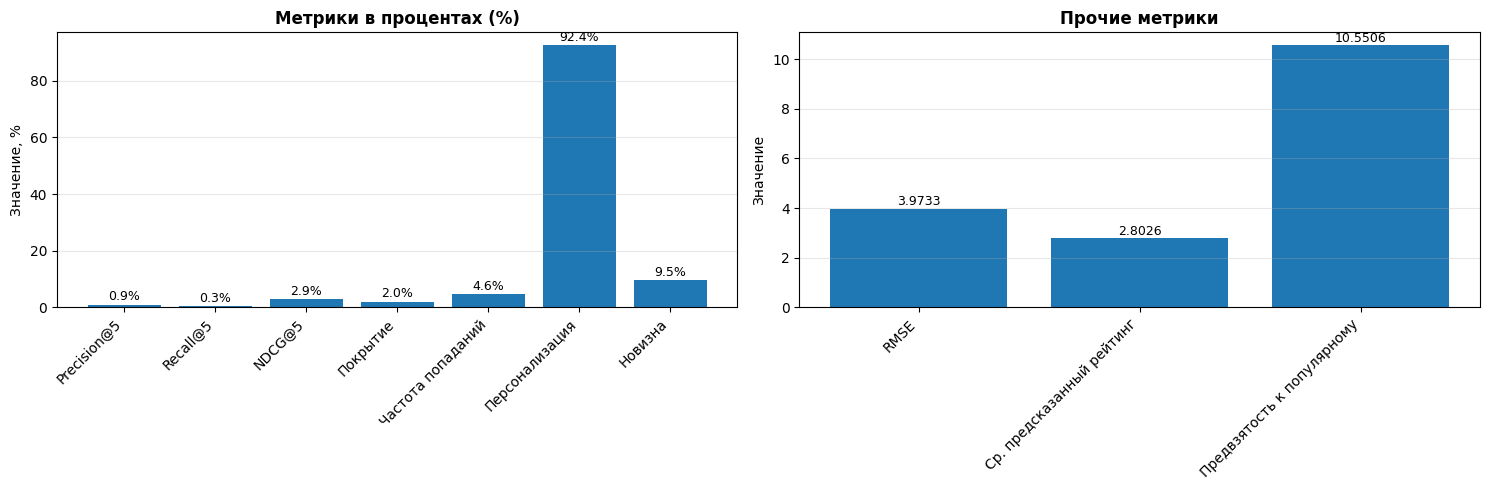

In [27]:
plt.figure(figsize=(15, 5))

# 1. Метрики в процентах
plt.subplot(1, 2, 1)
bars1 = plt.bar(percent_metrics, percent_values)
plt.title('Метрики в процентах (%)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Значение, %')
plt.grid(True, alpha=0.3, axis='y')
# Добавляем значения на столбцы
for bar, value in zip(bars1, percent_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Остальные метрики
plt.subplot(1, 2, 2)

bars2 = plt.bar(other_metrics, other_values)
plt.title('Прочие метрики', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Значение')
plt.grid(True, alpha=0.3, axis='y')
# Добавляем значения на столбцы
for bar, value in zip(bars2, other_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

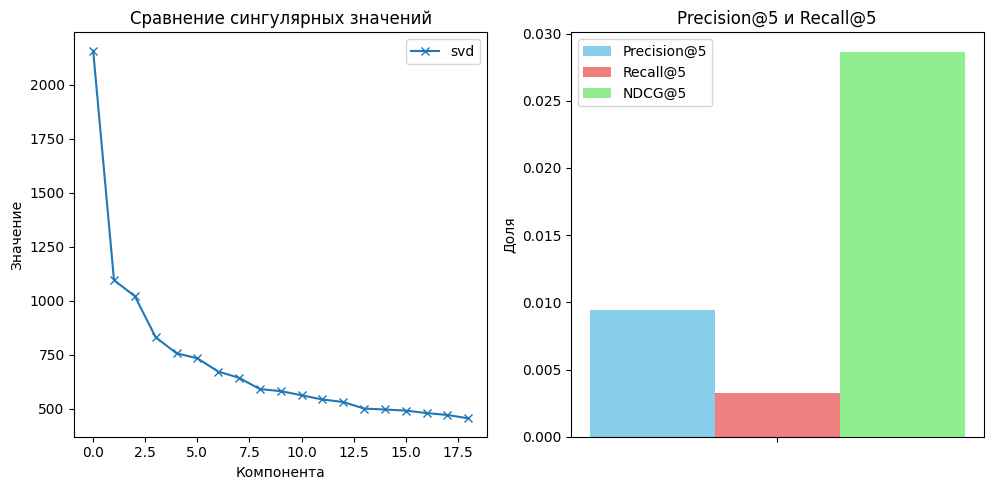

In [28]:
# визуализация сравнения
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(svd_sklearn.singular_values_, 'x-', label='svd')
plt.title('Сравнение сингулярных значений')
plt.xlabel('Компонента')
plt.ylabel('Значение')
plt.legend()

plt.subplot(1, 3, 2)
labels = ['']
x = np.arange(len(labels))
width = 0.25
plt.bar(x - width, [prec_sklearn], width, label='Precision@5', color='skyblue')
plt.bar(x, [rec_sklearn], width, label='Recall@5', color='lightcoral')
plt.bar(x + width, [ndcg_sklearn], width, label='NDCG@5', color='lightgreen')
plt.xticks(x, labels)
plt.title('Precision@5 и Recall@5')
plt.ylabel('Доля')
plt.legend()

plt.tight_layout()
plt.show()

# Итоговый проект: разработка гибридной системы рекомендаций книг с нейросетевыми моделями


## Этап 1. Улучшенная подготовка данных. Создание расширенных признаков:


In [30]:
class AdvancedFeatureEngineer:
    def __init__(self, df, tags_df):
        """
        Инициализация с двумя датасетами:
        - ratings_books_df: объединение ratings и books
        - tags_df: содержит book_tags и tags
        """
        self.df = df
        self.tags_df = tags_df

    def create_user_features(self):
        """Признаки пользователей"""
        print("Создание признаков пользователей...")

        # Базовые статистики
        user_stats = self.df.groupby('user_id').agg({
            'rating': ['mean', 'count', 'std']
        }).round(3)

        # УДАЛЯЕМ дублирующий признак (т.к. rating_count == unique_books)
        user_stats.columns = ['avg_rating', 'rating_count', 'rating_std']

        # Уровень активности
        if len(user_stats) >= 3:
            user_stats['activity_level'] = pd.qcut(
                user_stats['rating_count'],
                q=3,
                labels=['low', 'medium', 'high']
            )
        else:
            user_stats['activity_level'] = 'medium'

        return user_stats.reset_index()

    def create_book_features(self):
        """Признаки книг"""
        print("Создание признаков книг...")

        book_features = pd.DataFrame()
        book_features['book_id'] = self.df['book_id'].unique()

        # Для каждой книги собираем статистику
        book_stats = []

        for book_id in book_features['book_id']:
            book_data = self.df[self.df['book_id'] == book_id]

            # Базовые признаки
            stats_row = {
                'book_id': book_id,
                'avg_rating_book': book_data['rating'].mean(),
                'rating_count_book': len(book_data),
                'rating_std_book': book_data['rating'].std()
            }

            # Добавляем признаки из books, если они есть в df
            if 'average_rating' in self.df.columns:
                stats_row['avg_rating_global'] = book_data['average_rating'].iloc[0] if len(book_data) > 0 else np.nan

            if 'ratings_count' in self.df.columns:
                stats_row['ratings_count_global'] = book_data['ratings_count'].iloc[0] if len(book_data) > 0 else np.nan

            # Разнообразие оценок (если есть ratings_1 - ratings_5)
            rating_cols = [f'ratings_{i}' for i in range(1, 6)]
            available_cols = [col for col in rating_cols if col in self.df.columns]

            if available_cols and len(book_data) > 0:
                ratings_values = book_data[available_cols].iloc[0].values
                if sum(ratings_values) > 0:
                    stats_row['rating_diversity'] = np.std(ratings_values) / sum(ratings_values)

            # Возраст книги
            if 'original_publication_year' in self.df.columns and len(book_data) > 0:
                year = book_data['original_publication_year'].iloc[0]
                if pd.notna(year):
                    stats_row['book_age'] = 2024 - year

            book_stats.append(stats_row)

        book_features = pd.DataFrame(book_stats)

        # Добавляем популярность
        if 'rating_count_book' in book_features.columns:
            book_features['popularity_rank'] = book_features['rating_count_book'].rank(pct=True)

        # Добавляем теги
        if self.tags_df is not None:
            book_features = self._add_tags_features(book_features)

        return book_features

    def _add_tags_features(self, book_features):
        """Добавляет признаки из тегов"""
        if 'tag_name' in self.tags_df.columns and 'book_id' in self.tags_df.columns:
            # Группируем теги по книгам
            tag_stats = self.tags_df.groupby('book_id').agg({
                'tag_name': ['count', lambda x: len(set(x))]
            }).round(3)

            tag_stats.columns = ['tag_count', 'unique_tags']

            # Объединяем с признаками книг
            book_features = book_features.merge(tag_stats, on='book_id', how='left')

        return book_features

    def create_interaction_features(self):
        """Признаки взаимодействий"""
        print("Создание признаков взаимодействий...")

        interactions = self.df.copy()

        # 1. Схожесть с историей пользователя
        user_avg = self.df.groupby('user_id')['rating'].mean()
        interactions['rating_diff'] = interactions.apply(
            lambda x: abs(x['rating'] - user_avg.get(x['user_id'], x['rating'])),
            axis=1
        )

        # 2. Популярность для группы пользователей
        if 'book_id' in interactions.columns and 'user_id' in interactions.columns:
            # Средний рейтинг книги среди всех пользователей
            book_avg = self.df.groupby('book_id')['rating'].mean()
            interactions['book_popularity'] = interactions['book_id'].map(book_avg)

            # Для каждого пользователя: насколько книга популярнее его среднего
            interactions['relative_popularity'] = interactions['book_popularity'] - \
                interactions['user_id'].map(user_avg)

        return interactions

    def create_all_features(self):
        """Создает все признаки"""
        print("Начинаем создание признаков...")

        user_features = self.create_user_features()
        print(f"✓ Признаки пользователей созданы: {len(user_features)} записей")

        book_features = self.create_book_features()
        print(f"✓ Признаки книг созданы: {len(book_features)} записей")

        interaction_features = self.create_interaction_features()
        print(f"✓ Признаки взаимодействий созданы: {len(interaction_features)} записей")

        # Объединяем все в один датафрейм
        print("Объединение признаков...")

        # Объединяем взаимодействия с признаками пользователей и книг
        merged_features = interaction_features.merge(
            user_features, on='user_id', how='left'
        ).merge(
            book_features, on='book_id', how='left'
        )

        print(f"✓ Все признаки объединены. Итоговый размер: {len(merged_features)} строк")

        return {
            'user_features': user_features,
            'book_features': book_features,
            'interaction_features': interaction_features,
            'all_features': merged_features
        }

In [31]:
test_feature_engineer = AdvancedFeatureEngineer(df, df_tags)
all_features = test_feature_engineer.create_all_features()

# Доступ к отдельным компонентам:
user_features = all_features['user_features']
book_features = all_features['book_features']
interaction_features = all_features['interaction_features']
merged_features = all_features['all_features']

print(f"\nРезультат:")
print(f"- Признаков пользователей: {len(user_features)}")
print(f"- Признаков книг: {len(book_features)}")
print(f"- Взаимодействий: {len(interaction_features)}")
print(f"- Объединенный датасет: {len(merged_features)} строк")

Начинаем создание признаков...
Создание признаков пользователей...
✓ Признаки пользователей созданы: 53424 записей
Создание признаков книг...
✓ Признаки книг созданы: 10000 записей
Создание признаков взаимодействий...
✓ Признаки взаимодействий созданы: 5976479 записей
Объединение признаков...
✓ Все признаки объединены. Итоговый размер: 5976479 строк

Результат:
- Признаков пользователей: 53424
- Признаков книг: 10000
- Взаимодействий: 5976479
- Объединенный датасет: 5976479 строк


ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ПОЛЬЗОВАТЕЛЕЙ


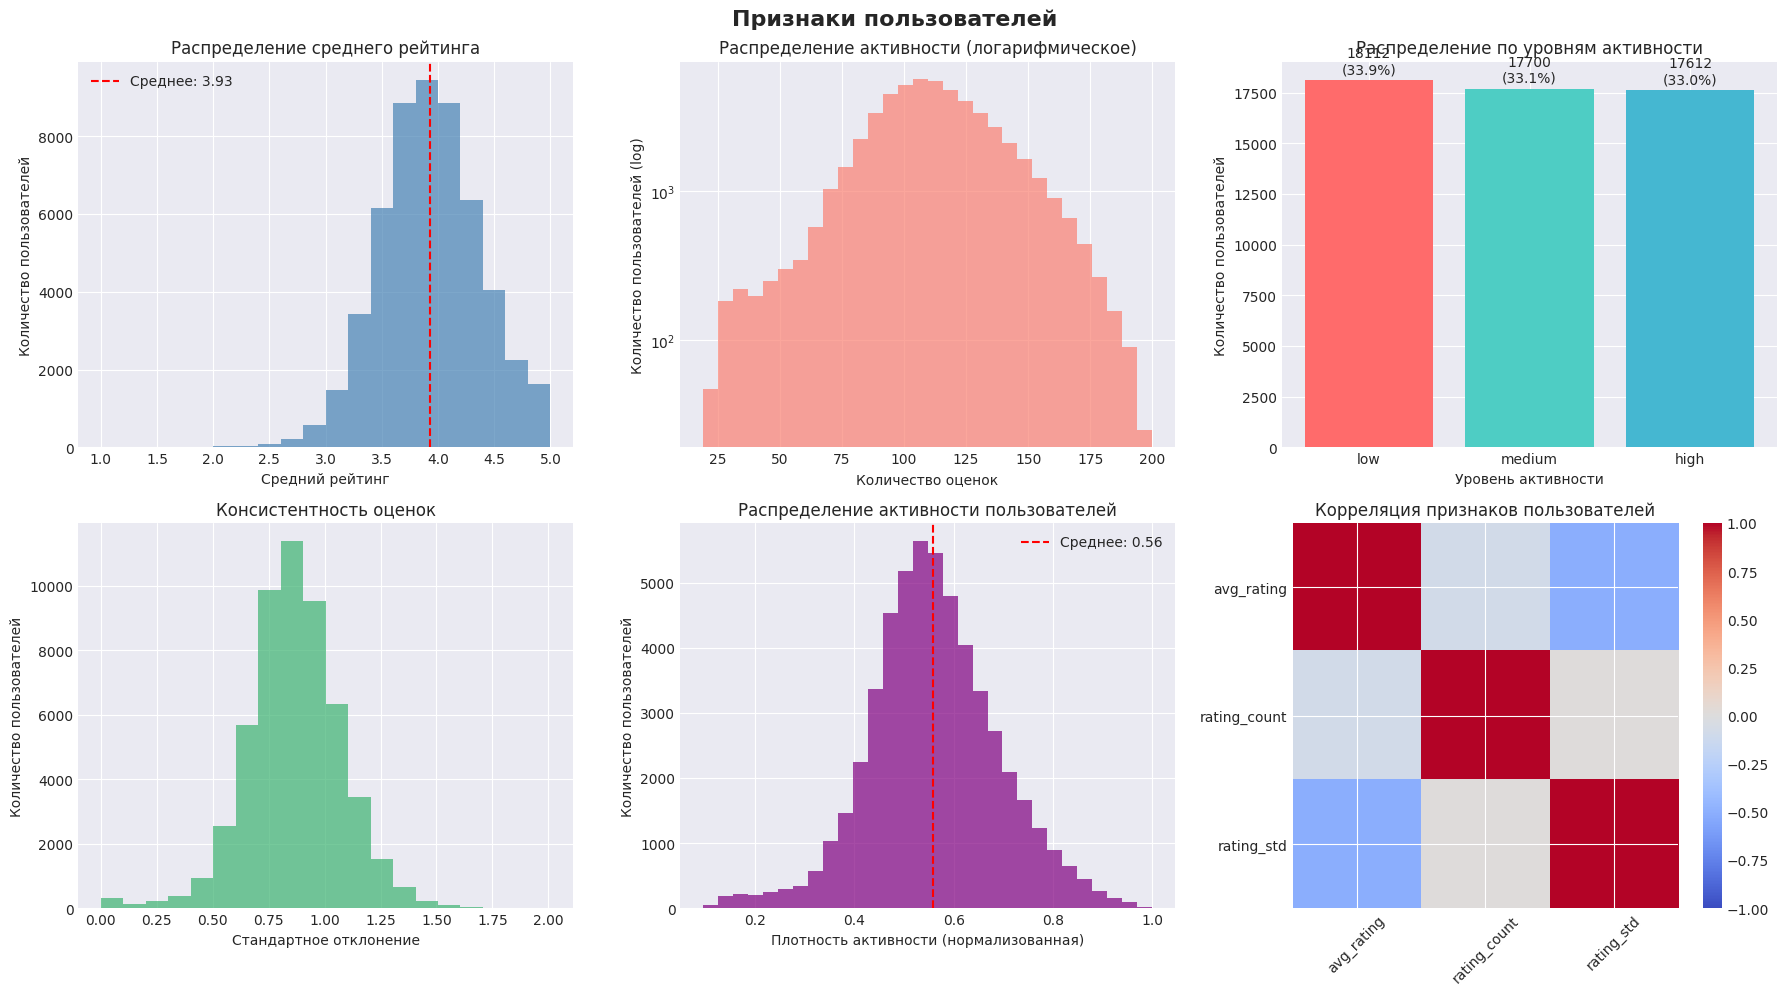


ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ КНИГ


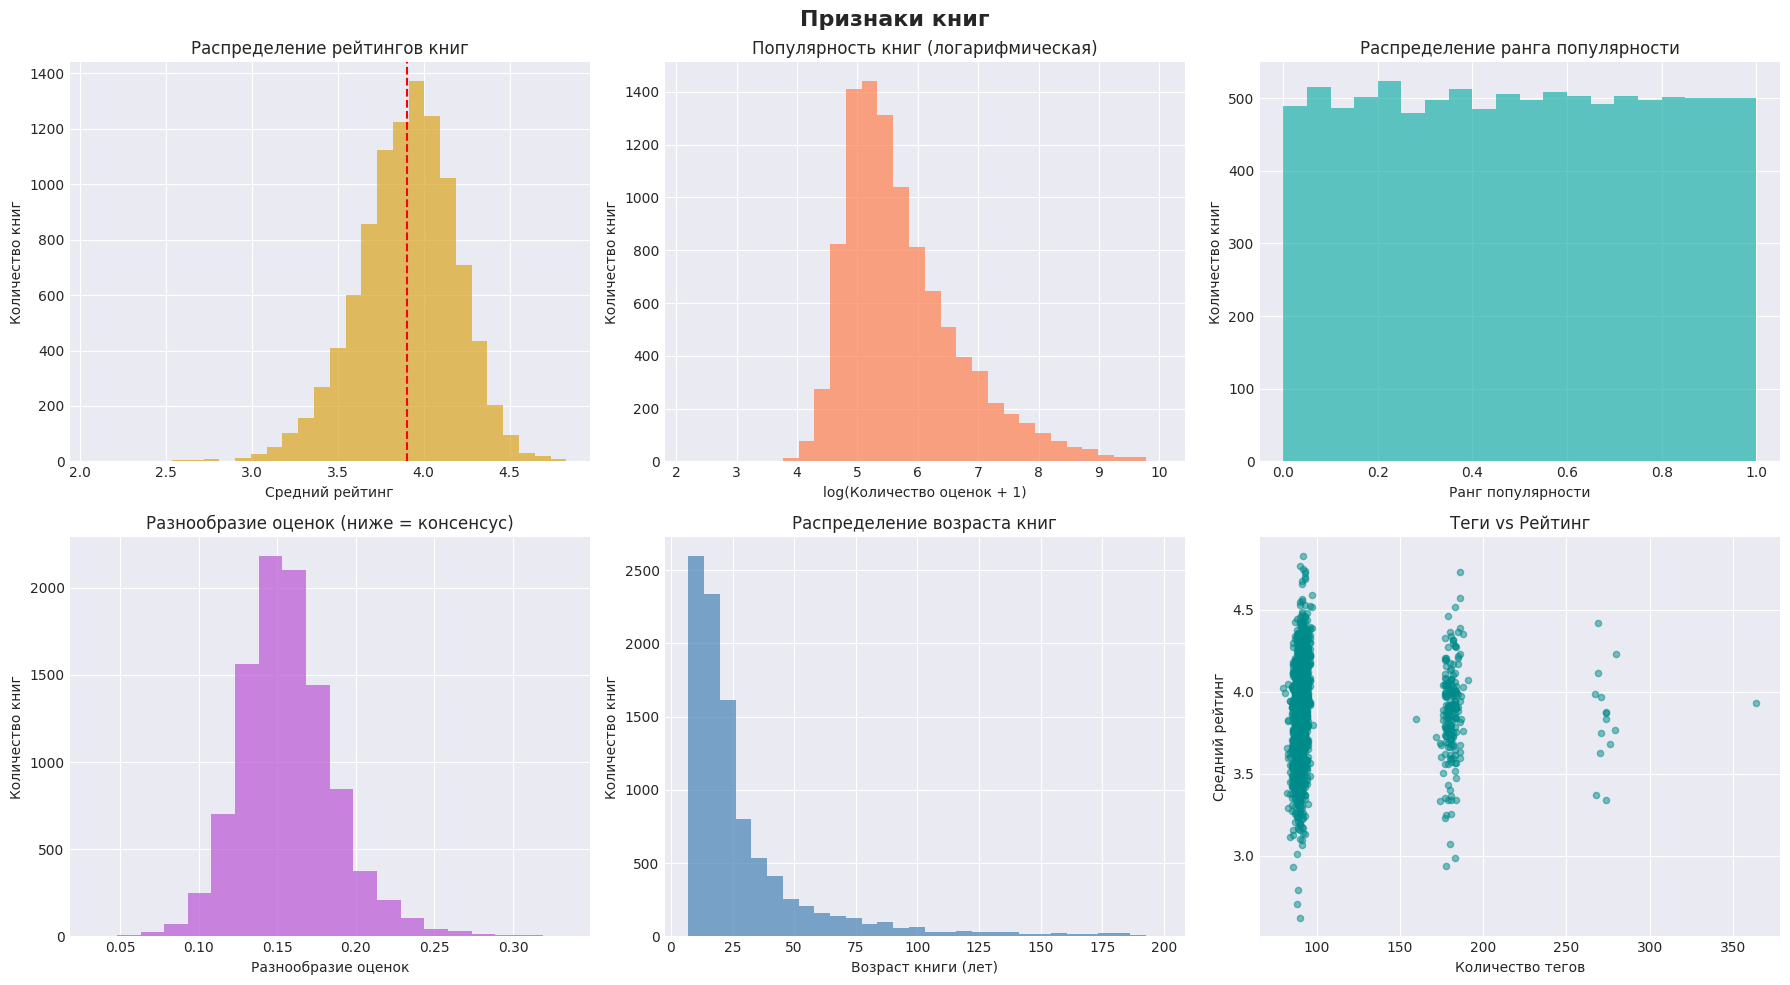


ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ВЗАИМОДЕЙСТВИЙ


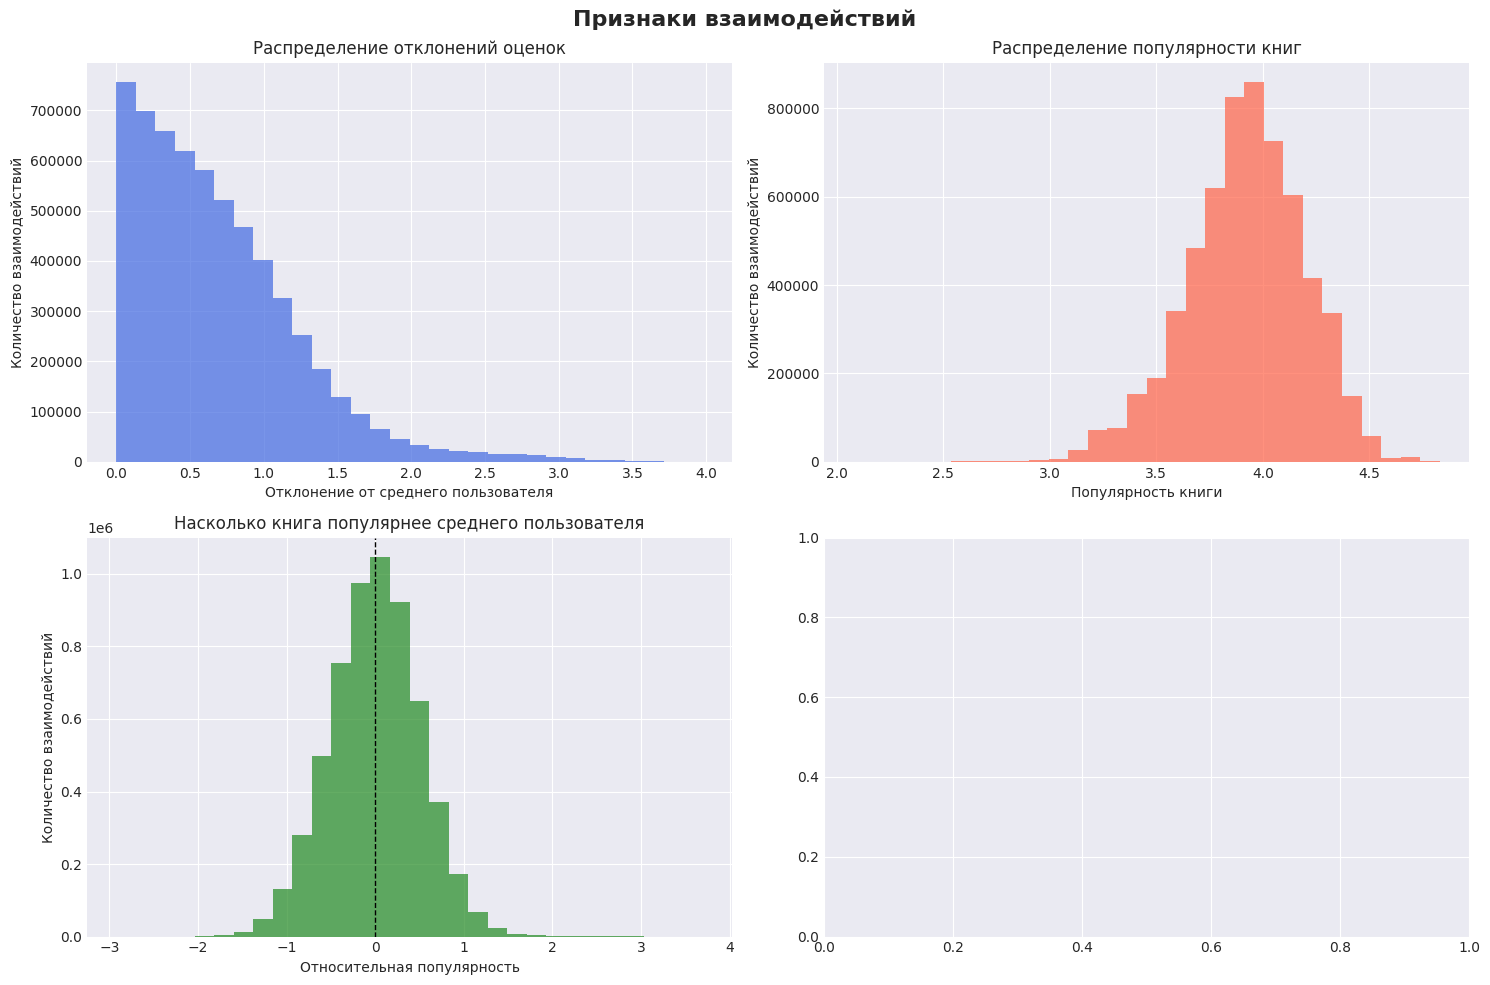


ЧИСЛОВЫЕ СВОДКИ ПРИЗНАКОВ

1. ПОЛЬЗОВАТЕЛИ:
----------------------------------------
Средний рейтинг пользователей: 3.93
Среднее количество оценок: 111.9
Максимальное количество оценок: 200

2. КНИГИ:
----------------------------------------
Средний рейтинг книг: 3.90
Среднее количество оценок на книгу: 597.6
Книг с тегами: 2062 (20.6%)

3. ВЗАИМОДЕЙСТВИЯ:
----------------------------------------
Всего взаимодействий: 5,976,479
Средний рейтинг в системе: 3.92
Среднее отклонение от пользовательского среднего: 0.69

4. ОБЩАЯ СТАТИСТИКА:
----------------------------------------
Всего пользователей: 53424
Всего книг: 10000
Плотность матрицы оценок: 1.1187%


In [32]:
def visualize_features(features_dict):
    """Визуализация всех созданных признаков"""

    user_features = features_dict['user_features']
    book_features = features_dict['book_features']
    interaction_features = features_dict['interaction_features']

    # Настройка стиля
    plt.style.use('seaborn-v0_8-darkgrid')

    # 1. ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ПОЛЬЗОВАТЕЛЕЙ
    print("=" * 60)
    print("ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ПОЛЬЗОВАТЕЛЕЙ")
    print("=" * 60)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Признаки пользователей', fontsize=16, fontweight='bold')

    # 1.1 Распределение среднего рейтинга пользователей
    if 'avg_rating' in user_features.columns:
        axes[0, 0].hist(user_features['avg_rating'].dropna(), bins=20, alpha=0.7, color='steelblue')
        axes[0, 0].set_xlabel('Средний рейтинг')
        axes[0, 0].set_ylabel('Количество пользователей')
        axes[0, 0].set_title('Распределение среднего рейтинга')
        axes[0, 0].axvline(user_features['avg_rating'].mean(), color='red', linestyle='--',
                           label=f'Среднее: {user_features["avg_rating"].mean():.2f}')
        axes[0, 0].legend()

    # 1.2 Распределение количества оценок
    if 'rating_count' in user_features.columns:
        axes[0, 1].hist(user_features['rating_count'], bins=30, alpha=0.7, color='salmon', log=True)
        axes[0, 1].set_xlabel('Количество оценок')
        axes[0, 1].set_ylabel('Количество пользователей (log)')
        axes[0, 1].set_title('Распределение активности (логарифмическое)')

    # 1.3 Уровень активности
    if 'activity_level' in user_features.columns:
        activity_counts = user_features['activity_level'].value_counts()
        axes[0, 2].bar(activity_counts.index, activity_counts.values,
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[0, 2].set_xlabel('Уровень активности')
        axes[0, 2].set_ylabel('Количество пользователей')
        axes[0, 2].set_title('Распределение по уровням активности')
        for i, v in enumerate(activity_counts.values):
            axes[0, 2].text(i, v + max(activity_counts.values)*0.01,
                            f'{v}\n({v/len(user_features)*100:.1f}%)',
                            ha='center', va='bottom')

    # 1.4 Стандартное отклонение оценок
    if 'rating_std' in user_features.columns:
        axes[1, 0].hist(user_features['rating_std'].dropna(), bins=20, alpha=0.7, color='mediumseagreen')
        axes[1, 0].set_xlabel('Стандартное отклонение')
        axes[1, 0].set_ylabel('Количество пользователей')
        axes[1, 0].set_title('Консистентность оценок')

    # 1.5 Плотность активности
    if 'rating_count' in user_features.columns and 'avg_rating' in user_features.columns:
        user_features['activity_density'] = user_features['rating_count'] / user_features['rating_count'].max()

        axes[1, 1].hist(user_features['activity_density'], bins=30, alpha=0.7, color='purple')
        axes[1, 1].set_xlabel('Плотность активности (нормализованная)')
        axes[1, 1].set_ylabel('Количество пользователей')
        axes[1, 1].set_title('Распределение активности пользователей')
        axes[1, 1].axvline(user_features['activity_density'].mean(), color='red',
                           linestyle='--', label=f'Среднее: {user_features["activity_density"].mean():.2f}')
        axes[1, 1].legend()

    # 1.6 Корреляция признаков пользователей
    if all(col in user_features.columns for col in ['avg_rating', 'rating_count', 'rating_std']):
        numeric_cols = ['avg_rating', 'rating_count', 'rating_std']
        corr_matrix = user_features[numeric_cols].corr()
        im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 2].set_xticks(range(len(numeric_cols)))
        axes[1, 2].set_yticks(range(len(numeric_cols)))
        axes[1, 2].set_xticklabels(numeric_cols, rotation=45)
        axes[1, 2].set_yticklabels(numeric_cols)
        axes[1, 2].set_title('Корреляция признаков пользователей')
        plt.colorbar(im, ax=axes[1, 2])

    plt.tight_layout()
    plt.show()

    # 2. ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ КНИГ
    print("\n" + "=" * 60)
    print("ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ КНИГ")
    print("=" * 60)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Признаки книг', fontsize=16, fontweight='bold')

    # 2.1 Средний рейтинг книг
    if 'avg_rating_book' in book_features.columns:
        axes[0, 0].hist(book_features['avg_rating_book'].dropna(), bins=30, alpha=0.7, color='goldenrod')
        axes[0, 0].set_xlabel('Средний рейтинг')
        axes[0, 0].set_ylabel('Количество книг')
        axes[0, 0].set_title('Распределение рейтингов книг')
        axes[0, 0].axvline(book_features['avg_rating_book'].mean(), color='red', linestyle='--')

    # 2.2 Количество оценок книг
    if 'rating_count_book' in book_features.columns:
        axes[0, 1].hist(np.log1p(book_features['rating_count_book']), bins=30, alpha=0.7, color='coral')
        axes[0, 1].set_xlabel('log(Количество оценок + 1)')
        axes[0, 1].set_ylabel('Количество книг')
        axes[0, 1].set_title('Популярность книг (логарифмическая)')

    # 2.3 Ранг популярности
    if 'popularity_rank' in book_features.columns:
        axes[0, 2].hist(book_features['popularity_rank'], bins=20, alpha=0.7, color='lightseagreen')
        axes[0, 2].set_xlabel('Ранг популярности')
        axes[0, 2].set_ylabel('Количество книг')
        axes[0, 2].set_title('Распределение ранга популярности')

    # 2.4 Разнообразие оценок
    if 'rating_diversity' in book_features.columns:
        axes[1, 0].hist(book_features['rating_diversity'].dropna(), bins=20, alpha=0.7, color='mediumorchid')
        axes[1, 0].set_xlabel('Разнообразие оценок')
        axes[1, 0].set_ylabel('Количество книг')
        axes[1, 0].set_title('Разнообразие оценок (ниже = консенсус)')

    # 2.5 Возраст книги
    if 'book_age' in book_features.columns:
        axes[1, 1].hist(book_features[book_features['book_age'] < 200]
                        ['book_age'].dropna(), bins=30, alpha=0.7, color='steelblue')
        axes[1, 1].set_xlabel('Возраст книги (лет)')
        axes[1, 1].set_ylabel('Количество книг')
        axes[1, 1].set_title('Распределение возраста книг')

    # 2.6 Теги книг
    if 'tag_count' in book_features.columns:
        axes[1, 2].scatter(book_features['tag_count'], book_features['avg_rating_book']
                           if 'avg_rating_book' in book_features.columns else book_features.index,
                           alpha=0.5, color='darkcyan', s=20)
        axes[1, 2].set_xlabel('Количество тегов')
        axes[1, 2].set_ylabel('Средний рейтинг')
        axes[1, 2].set_title('Теги vs Рейтинг')

    plt.tight_layout()
    plt.show()

    # 3. ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ВЗАИМОДЕЙСТВИЙ
    print("\n" + "=" * 60)
    print("ВИЗУАЛИЗАЦИЯ ПРИЗНАКОВ ВЗАИМОДЕЙСТВИЙ")
    print("=" * 60)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Признаки взаимодействий', fontsize=16, fontweight='bold')

    # 3.1 Отклонение от среднего рейтинга пользователя
    if 'rating_diff' in interaction_features.columns:
        axes[0, 0].hist(interaction_features['rating_diff'], bins=30, alpha=0.7, color='royalblue')
        axes[0, 0].set_xlabel('Отклонение от среднего пользователя')
        axes[0, 0].set_ylabel('Количество взаимодействий')
        axes[0, 0].set_title('Распределение отклонений оценок')

    # 3.2 Популярность книги для группы
    if 'book_popularity' in interaction_features.columns:
        axes[0, 1].hist(interaction_features['book_popularity'].dropna(), bins=30, alpha=0.7, color='tomato')
        axes[0, 1].set_xlabel('Популярность книги')
        axes[0, 1].set_ylabel('Количество взаимодействий')
        axes[0, 1].set_title('Распределение популярности книг')

    # 3.3 Относительная популярность
    if 'relative_popularity' in interaction_features.columns:
        axes[1, 0].hist(interaction_features['relative_popularity'].dropna(), bins=30, alpha=0.7, color='forestgreen')
        axes[1, 0].set_xlabel('Относительная популярность')
        axes[1, 0].set_ylabel('Количество взаимодействий')
        axes[1, 0].set_title('Насколько книга популярнее среднего пользователя')
        axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

    # 4. ЧИСЛОВЫЕ СВОДКИ
    print("\n" + "=" * 60)
    print("ЧИСЛОВЫЕ СВОДКИ ПРИЗНАКОВ")
    print("=" * 60)

    print("\n1. ПОЛЬЗОВАТЕЛИ:")
    print("-" * 40)
    if 'avg_rating' in user_features.columns:
        print(f"Средний рейтинг пользователей: {user_features['avg_rating'].mean():.2f}")
    if 'rating_count' in user_features.columns:
        print(f"Среднее количество оценок: {user_features['rating_count'].mean():.1f}")
        print(f"Максимальное количество оценок: {user_features['rating_count'].max()}")
    if 'unique_books' in user_features.columns:
        print(f"Среднее уникальных книг: {user_features['unique_books'].mean():.1f}")

    print("\n2. КНИГИ:")
    print("-" * 40)
    if 'avg_rating_book' in book_features.columns:
        print(f"Средний рейтинг книг: {book_features['avg_rating_book'].mean():.2f}")
    if 'rating_count_book' in book_features.columns:
        print(f"Среднее количество оценок на книгу: {book_features['rating_count_book'].mean():.1f}")
    if 'tag_count' in book_features.columns:
        books_with_tags = book_features['tag_count'].notna().sum()
        print(f"Книг с тегами: {books_with_tags} ({books_with_tags/len(book_features)*100:.1f}%)")

    print("\n3. ВЗАИМОДЕЙСТВИЯ:")
    print("-" * 40)
    print(f"Всего взаимодействий: {len(interaction_features):,}")
    if 'rating' in interaction_features.columns:
        print(f"Средний рейтинг в системе: {interaction_features['rating'].mean():.2f}")
    if 'rating_diff' in interaction_features.columns:
        print(f"Среднее отклонение от пользовательского среднего: {interaction_features['rating_diff'].mean():.2f}")

    print("\n4. ОБЩАЯ СТАТИСТИКА:")
    print("-" * 40)
    print(f"Всего пользователей: {len(user_features)}")
    print(f"Всего книг: {len(book_features)}")
    print(f"Плотность матрицы оценок: {len(interaction_features)/(len(user_features)*len(book_features))*100:.4f}%")


# Использование:
visualize_features(all_features)

### Вывод

**1. ФИЧИ ПОЛЬЗОВАТЕЛЕЙ (User Features)**

- `avg_rating` - средний рейтинг пользователя
- `rating_count` - количество поставленных оценок
- `rating_std` - стандартное отклонение оценок (консистентность)
- `activity_level` - уровень активности (low/medium/high) на основе квантилей rating_count

**2. ФИЧИ КНИГ (Book Features)**

- `avg_rating_book` - средний рейтинг книги
- `rating_count_book` - количество оценок книги
- `rating_std_book` - стандартное отклонение оценок книги
- `popularity_rank` - ранг популярности (percentile rank по rating_count_book)
- `rating_diversity` - разнообразие оценок (std(ratings_1-5) / total)
- `book_age` - возраст книги (2024 - original_publication_year)
- `tag_count` - общее количество тегов у книги
- `unique_tags` - количество уникальных тегов

**3. ФИЧИ ВЗАИМОДЕЙСТВИЙ (Interaction Features)**

- `rating_diff` - абсолютное отклонение от среднего рейтинга пользователя
- `book_popularity` - средний рейтинг книги среди всех пользователей
- `relative_popularity` - разница между популярностью книги и средним пользователя


## Этап 2. Построение гибридной системы


### План построения гибридной системы

Добавим FeatureBasedRecommender как пятую модель. Она будет использовать наши engineered features из AdvancedFeatureEngineer. Для предсказания можно использовать простую формулу: схожесть фичей пользователя и книги.

В HybridRecommender добавим использование user_features и book_features. Метод get_user_type будет смотреть на activity_level из фичей. Также добавим возможность использовать feature-based веса для моделей.

Интегрируем все готовые функции метрик. Система сможет сама оценивать качество через precision_recall_at_k, calculate_rmse и другие. Coverage, novelty, personalization тоже подключим.

Для работы с данными: система примет df (ratings+books) и df_tags. Сначала создаст фичи через AdvancedFeatureEngineer, затем обучит все модели.

Режимы работы расширим: добавим 'feature_boosted' где веса моделей зависят от фичей пользователя. Например, для пользователей с высоким rating_std больше вес content-based модели.

Кэширование сделаем умным: отдельно для каждого типа пользователя и стратегии. Фильтрация прочитанного будет использовать историю из ratings.

Метод evaluate будет использовать все наши готовые метрики, что даст полную картину качества системы.

Итог: система использует 5 моделей, фичи для персонализации, готовые метрики для оценки и адаптируется к типу пользователя.


In [72]:
from typing import Dict, List, Optional, Tuple, Union
from abc import ABC, abstractmethod

# ====================== БАЗОВЫЙ КЛАСС ======================


class BaseRecommender(ABC):
    def __init__(self, name: str, all_features):
        self.name = name
        self.is_fitted = False
        self.all_features = all_features

    @abstractmethod
    def fit(self, ratings_df: pd.DataFrame, books_df: pd.DataFrame, tags_df: pd.DataFrame):
        pass

    @abstractmethod
    def recommend(self, user_id: int, n: int = 10) -> List[int]:
        pass

    @abstractmethod
    def predict_rating(self, user_ids: List[int], book_id: List[int]) -> float:
        pass

# ====================== 1. ПОПУЛЯРНОСТЬ ======================

class PopularityRecommender(BaseRecommender):
    def __init__(self, all_features):
        super().__init__("Popularity", all_features)
        self.top_books = None
        self.book_rating_map = None

    def fit(self, ratings_df, books_df, tags_df):
        self.top_books = ratings_df.groupby('book_id')['rating'].agg(['count', 'mean']).reset_index()
        self.top_books['score'] = self.top_books['count'] * self.top_books['mean']
        self.top_books = self.top_books.sort_values('score', ascending=False)
        
        # Создаем словарь для O(1) доступа к рейтингам
        self.book_rating_map = dict(zip(self.top_books['book_id'], self.top_books['mean']))
        self.is_fitted = True

    def recommend(self, user_id, n=10):
        if not self.is_fitted:
            raise ValueError("Model not fitted")
        return self.top_books.head(n)['book_id'].tolist()

    def predict_rating(self, user_ids, book_ids):
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        # Векторизованный вариант с использованием map
        predictions = [self.book_rating_map.get(book_id, 3.5) for book_id in book_ids]
        
        return predictions if len(predictions) > 1 else predictions[0]

# ====================== 2. КОНТЕНТНАЯ ======================


class ContentBasedRecommender(BaseRecommender):
    def __init__(self, all_features):
        super().__init__("Content-Based", all_features)
        self.book_similarity = None
        self.book_ids = None
        self.user_history = None
        self.book_to_index = None

    def fit(self, ratings_df, books_df, tags_df):
        if tags_df is not None and 'tag_name' in tags_df.columns:
            tag_matrix = pd.crosstab(tags_df['book_id'], tags_df['tag_name'])
            self.book_similarity = cosine_similarity(tag_matrix)
            self.book_ids = tag_matrix.index.tolist()
        else:
            self.book_similarity = np.eye(len(books_df['book_id'].unique()))
            self.book_ids = books_df['book_id'].unique().tolist()

        self.book_to_index = {book_id: idx for idx, book_id in enumerate(self.book_ids)}
        
        self.user_history = ratings_df.groupby('user_id')['book_id'].apply(set).to_dict()
        self.is_fitted = True

    def recommend(self, user_id, n=10):
        if not self.is_fitted:
            return []

        user_books = self.user_history.get(user_id, set())
        
        # Фильтруем только книги, которые есть в индексе
        valid_user_books = [self.book_to_index[book_id] for book_id in user_books 
                           if book_id in self.book_to_index]
        
        if not valid_user_books:
            return []

        # Суммируем сходства за один проход
        similarity_scores = self.book_similarity[valid_user_books].sum(axis=0)
        
        # Обнуляем уже прочитанные книги
        for book_idx in valid_user_books:
            similarity_scores[book_idx] = 0
        
        # Получаем топ-N рекомендаций
        top_indices = np.argsort(similarity_scores)[::-1][:n]
        return [self.book_ids[idx] for idx in top_indices]

    def predict_rating(self, user_ids, book_ids):
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        predictions = []
        
        for user_id, book_id in tqdm(zip(user_ids, book_ids), 
                                    total=len(book_ids), 
                                    desc="Predicting ratings"):
            user_books = self.user_history.get(user_id, set())
            
            if book_id in self.book_to_index and user_books:
                book_idx = self.book_to_index[book_id]
                
                # Получаем индексы прочитанных книг
                user_book_indices = [self.book_to_index[b] for b in user_books 
                                    if b in self.book_to_index]
                
                if user_book_indices:
                    # Векторизованное вычисление сходства
                    similarities = self.book_similarity[book_idx, user_book_indices]
                    rating = np.mean(similarities) * 4 + 1
                    predictions.append(rating)
                else:
                    predictions.append(3.0)
            else:
                predictions.append(3.0)
        
        return predictions if len(predictions) > 1 else predictions[0]

# ====================== 3. КОЛЛАБОРАТИВНАЯ ======================


import numpy as np
from scipy import sparse
from tqdm import tqdm

class CollaborativeFilteringRecommender(BaseRecommender):
    def __init__(self, all_features, k=5):
        super().__init__("Item-Based CF", all_features)
        self.k = k
        self.user_item_matrix = None
        self.item_similarity = None
        self.user_ids = None
        self.book_ids = None
        self.user_to_idx = None  
        self.book_to_idx = None

    def fit(self, ratings_df, books_df, tags_df):
        # Создаем разреженную матрицу для экономии памяти
        self.user_item_matrix = ratings_df.pivot_table(
            index='user_id', columns='book_id', values='rating', fill_value=0
        )
        self.user_ids = self.user_item_matrix.index.tolist()
        self.book_ids = self.user_item_matrix.columns.tolist()
        
        # Кэшируем индексы для быстрого доступа
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        self.book_to_idx = {book_id: idx for idx, book_id in enumerate(self.book_ids)}
        
        # Конвертируем в numpy для скорости
        matrix_values = self.user_item_matrix.values
        
        # Векторизованное вычисление косинусного сходства
        norms = np.sqrt(np.square(matrix_values).sum(axis=0, keepdims=True))
        norms[norms == 0] = 1  # избегаем деления на ноль
        normalized_matrix = matrix_values / norms
        self.item_similarity = np.dot(normalized_matrix.T, normalized_matrix)
        
        # Обнуляем диагональ (самосходство)
        np.fill_diagonal(self.item_similarity, 0)
        
        self.is_fitted = True

    def recommend(self, user_id, n=10):
        if not self.is_fitted:
            return []

        user_idx = self.user_to_idx.get(user_id)
        if user_idx is None:
            return self.book_ids[:n]

        user_ratings = self.user_item_matrix.iloc[user_idx].values
        
        # Векторизованное предсказание рейтингов
        pred_ratings = np.dot(user_ratings, self.item_similarity)
        
        # Исключаем уже оцененные книги
        pred_ratings[user_ratings > 0] = -np.inf
        
        # Получаем топ-N индексов
        top_indices = np.argpartition(pred_ratings, -n)[-n:]
        top_indices = top_indices[np.argsort(pred_ratings[top_indices])[::-1]]
        
        return [self.book_ids[i] for i in top_indices]

    def predict_rating(self, user_ids, book_ids):
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        predictions = []
        matrix_values = self.user_item_matrix.values
        
        for user_id, book_id in tqdm(zip(user_ids, book_ids), 
                                    total=len(user_ids), 
                                    desc="Predicting CF ratings"):
            
            user_idx = self.user_to_idx.get(user_id)
            book_idx = self.book_to_idx.get(book_id)
            
            if user_idx is None or book_idx is None:
                predictions.append(3.0)
                continue
            
            user_ratings = matrix_values[user_idx]
            similarities = self.item_similarity[book_idx]
            
            # Маска оцененных книг
            rated_mask = user_ratings > 0
            
            if not np.any(rated_mask):
                predictions.append(3.0)
                continue
            
            # Фильтруем только оценки и сходства для оцененных книг
            rated_scores = user_ratings[rated_mask]
            rated_similarities = similarities[rated_mask]
            
            # Выбираем k ближайших соседей
            if len(rated_scores) > self.k:
                top_k_indices = np.argsort(rated_similarities)[-self.k:]
                rated_scores = rated_scores[top_k_indices]
                rated_similarities = rated_similarities[top_k_indices]
            
            # Взвешенное среднее
            weighted_sum = np.sum(rated_scores * rated_similarities)
            sum_weights = np.sum(rated_similarities)
            
            if sum_weights > 0:
                predictions.append(weighted_sum / sum_weights)
            else:
                predictions.append(3.0)
        
        return predictions if len(predictions) > 1 else predictions[0]

# ====================== 4. МАТРИЧНАЯ ФАКТОРИЗАЦИЯ ======================


class MatrixFactorizationRecommender(BaseRecommender):
    def __init__(self, all_features, n_factors=20):
        super().__init__("Matrix Factorization", all_features)
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.user_to_idx = None
        self.item_to_idx = None
        self.item_ids = None

    def fit(self, ratings_df, books_df, tags_df):
        # Создаем разреженную пользователь-книга матрицу
        user_item_matrix = ratings_df.pivot_table(
            index='user_id', columns='book_id', values='rating', fill_value=0
        )
        
        # Сохраняем маппинги
        user_ids = user_item_matrix.index.tolist()
        item_ids = user_item_matrix.columns.tolist()
        self.item_ids = item_ids
        
        # Создаем словари для быстрого поиска
        self.user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
        self.item_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids)}
        
        # Преобразуем в numpy array
        matrix = user_item_matrix.values.astype(np.float32)
        
        # Применяем SVD
        U, sigma, Vt = svds(matrix, k=self.n_factors)
        
        # Нормализуем факторы
        sigma_sqrt = np.sqrt(np.diag(sigma))
        self.user_factors = U @ sigma_sqrt
        self.item_factors = Vt.T @ sigma_sqrt
        
        self.is_fitted = True

    def recommend(self, user_id, n=10):
        if not self.is_fitted:
            return []
        
        user_idx = self.user_to_idx.get(user_id)
        if user_idx is None:
            return []
        
        # Векторизованное вычисление всех рейтингов
        user_vector = self.user_factors[user_idx]
        pred_ratings = self.item_factors @ user_vector
        
        # Получаем топ-N рекомендаций
        top_indices = np.argpartition(pred_ratings, -n)[-n:]
        top_indices = top_indices[np.argsort(pred_ratings[top_indices])[::-1]]
        
        return [self.item_ids[i] for i in top_indices]

    def predict_rating(self, user_ids, book_ids):
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        predictions = []
        
        for user_id, book_id in tqdm(zip(user_ids, book_ids), 
                                    total=len(user_ids), 
                                    desc="Predicting MF ratings"):
            
            user_idx = self.user_to_idx.get(user_id)
            book_idx = self.item_to_idx.get(book_id)
            
            if user_idx is None or book_idx is None:
                predictions.append(3.0)
                continue
            
            # Быстрое вычисление скалярного произведения
            rating = np.dot(self.user_factors[user_idx], self.item_factors[book_idx])
            
            # Клиппинг рейтинга к диапазону [0.5, 5.0]
            rating = np.clip(rating, 0.5, 5.0)
            predictions.append(rating)
        
        return predictions if len(predictions) > 1 else predictions[0]


# ====================== 5. FEATURE-BASED ======================


class FeatureBasedRecommender(BaseRecommender):
    def __init__(self, all_features):
        super().__init__("Feature-Based", all_features)
        self.user_features = None
        self.book_features = None
        self.user_history = None
        self.user_vector_cache = {}
        self.book_vector_cache = {}
        self.book_ids = None
        self.user_norm_cache = {}

    def fit(self, ratings_df, books_df, tags_df):
        self.user_features = self.all_features['user_features']
        self.book_features = self.all_features['book_features']
        self.user_history = ratings_df.groupby('user_id')['book_id'].apply(set).to_dict()
        
        # Подготавливаем списки фич
        self.user_numeric_cols = ['avg_rating', 'rating_count', 'rating_std']
        self.book_numeric_cols = [
            'avg_rating_book', 'rating_count_book', 'rating_std_book',
            'popularity_rank', 'rating_diversity'
        ]
        
        # Отфильтровываем только существующие колонки
        self.user_numeric_cols = [col for col in self.user_numeric_cols 
                                 if col in self.user_features.columns]
        self.book_numeric_cols = [col for col in self.book_numeric_cols 
                                 if col in self.book_features.columns]
        
        self.user_vectors = {}
        for _, row in self.user_features.iterrows():
            user_id = row['user_id']
            vector = row[self.user_numeric_cols].values.astype(np.float32)
            self.user_vectors[user_id] = vector
            self.user_norm_cache[user_id] = np.linalg.norm(vector) + 1e-8
        
        self.book_vectors = {}
        for _, row in self.book_features.iterrows():
            book_id = row['book_id']
            vector = row[self.book_numeric_cols].values.astype(np.float32)
            self.book_vectors[book_id] = vector
        
        self.book_ids = self.book_features['book_id'].unique().tolist()
        self.is_fitted = True

    def _get_user_feature_vector(self, user_id):
        """Получение вектора пользователя из кэша"""
        return self.user_vectors.get(user_id, np.array([3.5, 10, 1.0], dtype=np.float32))

    def _get_book_feature_vector(self, book_id):
        """Получение вектора книги из кэша"""
        return self.book_vectors.get(book_id, np.array([3.5, 10, 1.0, 0.5, 0.5], dtype=np.float32))

    def recommend(self, user_id, n=10):
        if not self.is_fitted:
            return []

        user_vector = self._get_user_feature_vector(user_id)
        read_books = self.user_history.get(user_id, set())
        
        # Предварительно вычисляем норму пользователя
        user_norm = np.linalg.norm(user_vector) + 1e-8
        
        # Векторизованный расчет скор для всех книг
        scores = {}
        for book_id in self.book_ids:
            if book_id not in read_books:
                book_vector = self.book_vectors.get(book_id)
                if book_vector is not None:
                    # Берем часть вектора книги соответствующую длине вектора пользователя
                    book_slice = book_vector[:len(user_vector)]
                    book_norm = np.linalg.norm(book_slice) + 1e-8
                    similarity = np.dot(user_vector, book_slice) / (user_norm * book_norm)
                    scores[book_id] = similarity
        
        # Используем nlargest для эффективного поиска топ-N
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
        return [book_id for book_id, _ in top_items]

    def predict_rating(self, user_ids, book_ids):
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        predictions = []
        
        for user_id, book_id in tqdm(zip(user_ids, book_ids), 
                                    total=len(user_ids), 
                                    desc="Predicting Feature ratings"):
            
            user_vector = self._get_user_feature_vector(user_id)
            book_vector = self._get_book_feature_vector(book_id)
            
            if len(user_vector) > 0 and len(book_vector) > 0:
                # Берем общую часть векторов
                min_len = min(len(user_vector), len(book_vector))
                user_slice = user_vector[:min_len]
                book_slice = book_vector[:min_len]
                
                # Вычисляем косинусное сходство
                user_norm = np.linalg.norm(user_slice) + 1e-8
                book_norm = np.linalg.norm(book_slice) + 1e-8
                similarity = np.dot(user_slice, book_slice) / (user_norm * book_norm)
                
                # Масштабируем к диапазону 1-5
                rating = np.clip(similarity * 2 + 3, 1, 5)
                predictions.append(float(rating))
            else:
                predictions.append(3.0)
        
        return predictions if len(predictions) > 1 else predictions[0]

## Продвинутая часть (дополнительная)


In [71]:
class SimpleTwoTowerRecommender(BaseRecommender):
    """Упрощенная Two-Tower модель с использованием готовых фичей и тегов"""
    def __init__(self, all_features, embedding_dim=16):
        super().__init__("Two-Tower NN", all_features)
        self.embedding_dim = embedding_dim
        
        self.user_features = all_features['user_features']
        self.book_features = all_features['book_features']
        
        self.user_embeddings_matrix = None
        self.book_embeddings_matrix = None
        self.user_id_to_idx = None
        self.book_id_to_idx = None
        self.book_ids = None
        self.top_tags = None
        self.tag_matrix = None
        
    def _prepare_features_with_tags(self, tags_df):
        """Подготовка фичей с тегами с оптимизациями"""
        # 1. User features
        user_cols = ['avg_rating', 'rating_count', 'rating_std']
        if 'activity_level' in self.user_features.columns:
            activity_map = {'low': 0, 'medium': 1, 'high': 2}
            self.user_features['activity_numeric'] = (
                self.user_features['activity_level']
                .map(activity_map)
                .fillna(1)
                .astype(np.float32)
            )
            user_cols.append('activity_numeric')
        
        user_numeric = self.user_features[user_cols].fillna(0).values.astype(np.float32)
        
        # 2. Book features
        book_cols = ['avg_rating_book', 'rating_count_book', 'rating_std_book', 
                    'popularity_rank', 'book_age', 'tag_count']
        book_cols = [col for col in book_cols if col in self.book_features.columns]
        book_numeric = self.book_features[book_cols].fillna(0).values.astype(np.float32)
        
        # 3. Tag features (если есть)
        if tags_df is not None and 'tag_name' in tags_df.columns:
            # Берем топ-50 тегов
            self.top_tags = tags_df['tag_name'].value_counts().head(50).index.tolist()
            
            # Создаем tag_matrix с оптимизацией
            tag_matrix = pd.crosstab(tags_df['book_id'], tags_df['tag_name'])
            tag_matrix = tag_matrix.reindex(columns=self.top_tags, fill_value=0)
            
            # Сопоставляем с книгами
            book_ids = self.book_features['book_id'].values
            tag_features = np.zeros((len(book_ids), len(self.top_tags)), dtype=np.float32)
            
            # Создаем маппинг индексов
            book_to_idx = {bid: idx for idx, bid in enumerate(book_ids)}
            tag_book_indices = [book_to_idx.get(bid) for bid in tag_matrix.index 
                              if bid in book_to_idx]
            
            if tag_book_indices:
                valid_indices = [i for i in tag_book_indices if i is not None]
                if valid_indices:
                    tag_features[valid_indices] = tag_matrix.loc[
                        tag_matrix.index.isin(book_to_idx)
                    ].values
            
            book_all = np.hstack([book_numeric, tag_features])
            self.tag_matrix = tag_features
        else:
            book_all = book_numeric
            self.tag_matrix = None
        
        return user_numeric, book_all
    
    def fit(self, ratings_df, books_df, tags_df):
        """Обучение модели с тегами"""
        print("Обучение Two-Tower модели...")
        
        # Подготовка фичей с тегами
        user_feats, book_feats = self._prepare_features_with_tags(tags_df)
        
        # Создаем маппинги
        user_ids = self.user_features['user_id'].values
        book_ids = self.book_features['book_id'].values
        self.book_ids = book_ids.tolist()
        
        self.user_id_to_idx = {uid: i for i, uid in enumerate(user_ids)}
        self.book_id_to_idx = {bid: i for i, bid in enumerate(book_ids)}
        
        # Определяем общую размерность
        common_dim = min(self.embedding_dim, user_feats.shape[1], book_feats.shape[1])
        
        # Обучаем SVD
        user_svd = TruncatedSVD(n_components=common_dim, random_state=42)
        self.user_embeddings_matrix = user_svd.fit_transform(user_feats).astype(np.float32)
        
        book_svd = TruncatedSVD(n_components=common_dim, random_state=42)
        self.book_embeddings_matrix = book_svd.fit_transform(book_feats).astype(np.float32)
        
        print(f"✓ Two-Tower модель обучена: {len(user_ids)} users, {len(book_ids)} books")
        if self.tag_matrix is not None:
            print(f"✓ Использовано тегов: {len(self.top_tags)}")
        self.is_fitted = True
    
    def recommend(self, user_id, n=10):
        """Рекомендации через матричное умножение"""
        if not self.is_fitted:
            return []
        
        user_idx = self.user_id_to_idx.get(user_id)
        if user_idx is None:
            return []
        
        # Векторизованное вычисление всех similarity
        user_emb = self.user_embeddings_matrix[user_idx]
        all_similarities = self.book_embeddings_matrix @ user_emb
        
        # Получаем топ-N индексов
        top_indices = np.argpartition(all_similarities, -n)[-n:]
        top_indices = top_indices[np.argsort(all_similarities[top_indices])[::-1]]
        
        return [self.book_ids[i] for i in top_indices]
    
    def predict_rating(self, user_ids: Union[int, List[int]], 
                      book_ids: Union[int, List[int]]) -> Union[float, List[float]]:
        """Предсказание рейтингов"""
        if isinstance(user_ids, int):
            user_ids = [user_ids]
        if isinstance(book_ids, int):
            book_ids = [book_ids]
        
        predictions = []
        user_norms = {}
        
        for user_id, book_id in tqdm(zip(user_ids, book_ids), 
                                    total=len(user_ids), 
                                    desc="Predicting TT ratings"):
            
            user_idx = self.user_id_to_idx.get(user_id)
            book_idx = self.book_id_to_idx.get(book_id)
            
            if user_idx is None or book_idx is None:
                predictions.append(3.0)
                continue
            
            user_emb = self.user_embeddings_matrix[user_idx]
            book_emb = self.book_embeddings_matrix[book_idx]
            
            # Кэшируем норму пользователя
            if user_id not in user_norms:
                user_norms[user_id] = np.linalg.norm(user_emb) + 1e-8
            
            # Вычисляем косинусное сходство
            similarity = np.dot(user_emb, book_emb) / (
                user_norms[user_id] * (np.linalg.norm(book_emb) + 1e-8)
            )
            
            # Масштабируем к 1-5
            rating = np.clip(similarity * 2 + 3, 1, 5)
            predictions.append(float(rating))
        
        return predictions if len(predictions) > 1 else predictions[0]

## Гибридная система


In [86]:
# all_features Данные можно передавать сразу для гибкой перестройки но для удобства обвялено глобально в данный момент. Для экономия времени

class HybridRecommender:
    def __init__(self, ratings_df: pd.DataFrame, books_df: pd.DataFrame, tags_df: pd.DataFrame, all_features):
        self.ratings_df = ratings_df
        self.books_df = books_df
        self.tags_df = tags_df

        # Инициализация всех моделей
        self.models = {
            'popularity': PopularityRecommender(all_features),
            'content': ContentBasedRecommender(all_features),
            'collaborative': CollaborativeFilteringRecommender(all_features),
            'mf': MatrixFactorizationRecommender(all_features, n_factors=20),
            'feature': FeatureBasedRecommender(all_features),
            'two_tower': SimpleTwoTowerRecommender(all_features)  
        }

        # Веса по умолчанию
        self.weights = {
            'popularity': 0.15,
            'content': 0.25,
            'collaborative': 0.25,
            'mf': 0.20,
            'feature': 0.15,
            'two_tower': 0.25 
        }

        # Кэш
        self.recommendation_cache = {}
        self.user_features = None
        self.book_features = None

        # Инициализация feature engineer
        self._init_features()

    def _init_features(self):
        """Инициализация фичей через AdvancedFeatureEngineer"""

        self.user_features = all_features['user_features']
        self.book_features = all_features['book_features']

    def train_all_models(self):
        """Обучение всех моделей"""
        print("Обучение моделей...")
        for name, model in self.models.items():
            print(f"  {name}...")
            model.fit(self.ratings_df, self.books_df, self.tags_df)
        print("Все модели обучены!")

    def get_user_type(self, user_id: int) -> str:
        """Определение типа пользователя"""
        if self.user_features is None:
            self._init_features()

        user_data = self.user_features[self.user_features['user_id'] == user_id]

        if len(user_data) == 0:
            return 'new'

        if 'rating_count' in user_data.columns:
            rating_count = user_data['rating_count'].iloc[0]
            if rating_count < 5:
                return 'new'
            elif rating_count > 50:
                return 'active'

        return 'regular'

    def set_model_weights(self, weights: Dict[str, float]):
        """Установка весов моделей"""
        total = sum(weights.values())
        if total > 0:
            self.weights = {k: v/total for k, v in weights.items()}

    def get_feature_based_weights(self, user_id: int) -> Dict[str, float]:
        """Веса моделей на основе фичей пользователя"""
        if self.user_features is None:
            return self.weights

        user_data = self.user_features[self.user_features['user_id'] == user_id]
        if len(user_data) == 0:
            return self.weights

        base_weights = self.weights.copy()

        # Настройка весов на основе фичей
        if 'rating_std' in user_data.columns:
            rating_std = user_data['rating_std'].iloc[0]
            # Если пользователь непоследователен, больше доверяем content-based
            if rating_std > 1.5:
                base_weights['content'] *= 1.3
                base_weights['collaborative'] *= 0.8

        if 'activity_level' in user_data.columns:
            activity = user_data['activity_level'].iloc[0]
            # Активным пользователям больше CF и MF
            if activity == 'high':
                base_weights['collaborative'] *= 1.2
                base_weights['mf'] *= 1.2
                base_weights['popularity'] *= 0.7

        # Нормализация
        total = sum(base_weights.values())
        return {k: v/total for k, v in base_weights.items()}

    def get_recommendations(self, user_id: int, n: int = 10,
                            strategy: str = 'hybrid') -> List[int]:
        """Получение рекомендаций"""
        cache_key = f"{user_id}_{n}_{strategy}"
        if cache_key in self.recommendation_cache:
            return self.recommendation_cache[cache_key]

        # Фильтрация прочитанных книг
        read_books = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['book_id'])

        if strategy == 'hybrid':
            recs = self._hybrid_recommend(user_id, n, read_books)
        elif strategy == 'weighted':
            recs = self._weighted_recommend(user_id, n, read_books)
        elif strategy == 'feature_boosted':
            recs = self._feature_boosted_recommend(user_id, n, read_books)
        elif strategy == 'cascade':
            recs = self._cascade_recommend(user_id, n, read_books)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # Фильтрация и кэширование
        recs = [book for book in recs if book not in read_books][:n]
        self.recommendation_cache[cache_key] = recs

        return recs

    def _hybrid_recommend(self, user_id: int, n: int, read_books: set) -> List[int]:
        """Гибридные рекомендации по типу пользователя"""
        user_type = self.get_user_type(user_id)

        if user_type == 'new':
            # Новым: популярность + контент
            pop_recs = self.models['popularity'].recommend(user_id, n*2)
            content_recs = self.models['content'].recommend(user_id, n)
            recs = list(dict.fromkeys(pop_recs + content_recs))

        elif user_type == 'active':
            # Активным: все модели со взвешенным усреднением
            recs = self._weighted_recommend(user_id, n*2, read_books)

        else:  # regular
            # Обычным: взвешенное усреднение
            recs = self._weighted_recommend(user_id, n, read_books)

        return recs

    def _weighted_recommend(self, user_id: int, n: int, read_books: set) -> List[int]:
        """Взвешенное усреднение рекомендаций"""
        candidate_scores = {}

        for model_name, model in self.models.items():
            weight = self.weights.get(model_name, 0.2)
            model_recs = model.recommend(user_id, n*3)

            for i, book_id in enumerate(model_recs):
                if book_id not in read_books:
                    score = weight * (len(model_recs) - i) / len(model_recs)
                    candidate_scores[book_id] = candidate_scores.get(book_id, 0) + score

        sorted_recs = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
        return [book_id for book_id, _ in sorted_recs[:n]]

    def _feature_boosted_recommend(self, user_id: int, n: int, read_books: set) -> List[int]:
        """Рекомендации с весами на основе фичей"""
        weights = self.get_feature_based_weights(user_id)
        candidate_scores = {}

        for model_name, model in self.models.items():
            weight = weights.get(model_name, 0.2)
            model_recs = model.recommend(user_id, n*2)

            for i, book_id in enumerate(model_recs):
                if book_id not in read_books:
                    score = weight * (len(model_recs) - i) / len(model_recs)
                    candidate_scores[book_id] = candidate_scores.get(book_id, 0) + score

        sorted_recs = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
        return [book_id for book_id, _ in sorted_recs[:n]]

    def _cascade_recommend(self, user_id: int, n: int, read_books: set) -> List[int]:
        """Каскадные рекомендации"""
        # Этап 1: Кандидаты от всех моделей
        all_candidates = set()
        for model in self.models.values():
            all_candidates.update(model.recommend(user_id, n*3))

        # Этап 2: Ранжирование взвешенным предсказанием
        candidate_scores = {}
        weights = self.get_feature_based_weights(user_id)

        for book_id in all_candidates:
            if book_id not in read_books:
                pred_score = self.predict_rating(user_id, book_id, weights)
                candidate_scores[book_id] = pred_score

        # Этап 3: Возврат топ-N
        sorted_recs = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
        return [book_id for book_id, _ in sorted_recs[:n]]

    def predict_rating(self, user_ids, book_ids, weights: Optional[Dict[str, float]] = None):
        """Предсказание оценок взвешенным способом для списков"""
        if weights is None:
            weights = self.weights
        
        # Обработка одиночных значений
        single_user = isinstance(user_ids, int)
        single_book = isinstance(book_ids, int)
        
        if single_user:
            user_ids = [user_ids]
        if single_book:
            book_ids = [book_ids]
        
        # Проверка длины списков
        if len(user_ids) != len(book_ids):
            raise ValueError("user_ids и book_ids должны иметь одинаковую длину")
        
        n_predictions = len(user_ids)
        
        # Собираем предсказания от всех моделей
        model_predictions = {}
        for model_name, model in self.models.items():
            if model.is_fitted:
                # Каждая модель возвращает список предсказаний
                preds = model.predict_rating(user_ids, book_ids)
                if isinstance(preds, float):  # На случай, если модель вернула одно значение
                    preds = [preds] * n_predictions
                model_predictions[model_name] = preds
        
        # Если нет предсказаний от моделей
        if not model_predictions:
            result = [3.0] * n_predictions
            return result[0] if single_user and single_book else result
        
        # Взвешенное усреднение
        final_predictions = []
        for i in range(n_predictions):
            predictions = []
            model_weights = []
        

            for model_name, pred_list in model_predictions.items():
                if isinstance(pred_list, list):
                    pred = pred_list[i]
                else:
                    pred = pred_list

                if pred is not None:
                    predictions.append(pred)
                    model_weights.append(weights.get(model_name, 0.2))
            
            if predictions:
                final_predictions.append(np.average(predictions, weights=model_weights))
            else:
                final_predictions.append(3.0)
        
        # Возвращаем в том же формате, что и приняли
        if single_user and single_book:
            return final_predictions[0]
        return final_predictions

    def get_similar_books(self, book_id: int, n: int = 5) -> List[int]:
        """Похожие книги"""
        return self.models['content'].recommend(None, n)

    # ====================== ИНТЕГРАЦИЯ С МЕТРИКАМИ ======================

    def evaluate(self, test_df: pd.DataFrame, k: int = 5) -> Dict[str, float]:
        """Оценка качества через готовые метрики"""
        
        # Подготовка данных для метрик
        test_mat, _, _ = prepare_matrix(test_df)

        user_sample = test_df['user_id'].unique()

        # Подготовка данных для метрик
        _, idx_to_user, idx_to_book = prepare_matrix(test_df)
        user_to_idx = {v: k for k, v in idx_to_user.items()}
        book_to_idx = {v: k for k, v in idx_to_book.items()}

        n_users = len(idx_to_user)
        n_books = len(idx_to_book)
        pred_matrix = np.zeros((n_users, n_books), dtype=np.float64)


        prediction_pairs = []
        pair_indices = []

        for user_id in tqdm(user_sample, desc="Сбор пар для предсказаний"):
            if user_id in user_to_idx:
                user_idx = user_to_idx[user_id]
                
                # Получаем все книги из теста для этого пользователя
                user_books = test_df[test_df['user_id'] == user_id]['book_id'].unique()
                
                for book_id in user_books:
                    if book_id in book_to_idx:
                        prediction_pairs.append((user_id, book_id))
                        pair_indices.append((user_idx, book_to_idx[book_id]))

        if prediction_pairs:
            # Разделяем на списки для batch-обработки
            user_ids_batch, book_ids_batch = zip(*prediction_pairs)
            
            # Получаем все предсказания за один вызов
            predicted_ratings = self.predict_rating(list(user_ids_batch), list(book_ids_batch))
            
            # Заполняем матрицу
            for (user_idx, book_idx), rating in tqdm(zip(pair_indices, predicted_ratings), total=len(predicted_ratings), desc="Заполнение матрицы"):
                pred_matrix[user_idx, book_idx] = rating

                            
        # Использование готовых функций метрик
        metrics = {}

        metrics['RMSE'] = calculate_rmse(pred_matrix, test_mat)

        # Precision и Recall и NDCG
        precision, recall, ndcg = precision_recall_at_k(pred_matrix, test_mat, k=k)
        metrics['precision@k'] = precision
        metrics['recall@k'] = recall
        metrics['NDCG@K'] = ndcg

        return metrics

    def _prepare_test_matrix(self, test_df: pd.DataFrame):
        """Подготовка тестовой матрицы для метрик"""
        return test_df.pivot_table(
            index='user_id', columns='book_id', values='rating', fill_value=0
        )

    def get_recommendations_matrix(self, user_ids: List[int], n: int = 5) -> Dict[int, List[int]]:
        """Матрица рекомендаций для нескольких пользователей"""
        recs = {}
        for user_id in user_ids:
            recs[user_id] = self.get_recommendations(user_id, n=n)
        return recs

# ====================== ИСПОЛЬЗОВАНИЕ ======================


def create_and_train_hybrid_system(ratings_df, books_df, tags_df):
    """Создание и обучение гибридной системы"""
    print("Инициализация гибридной системы...")
    system = HybridRecommender(ratings_df, books_df, tags_df, all_features)

    system.train_all_models()

    # Настройка весов
    system.set_model_weights({
        'popularity': 0.15,
        'content': 0.25,
        'collaborative': 0.25,
        'mf': 0.20,
        'feature': 0.15,
        'two_tower': 0.25 
    })

    print("Система готова к работе!")
    return system


hybrid_system = create_and_train_hybrid_system(df, df, df_tags)

Инициализация гибридной системы...
Обучение моделей...
  popularity...
  content...
  collaborative...
  mf...
  feature...
  two_tower...
Обучение Two-Tower модели...
✓ Two-Tower модель обучена: 53424 users, 10000 books
✓ Использовано тегов: 50
Все модели обучены!
Система готова к работе!


In [103]:
# Получение рекомендаций
user_id = list(user_map.keys())[51]
book_id = list(book_map.keys())[51]

print(f"=== РЕКОМЕНДАЦИИ ДЛЯ ПОЛЬЗОВАТЕЛЯ {user_id} ===")
recs = hybrid_system.get_recommendations(user_id, n=10, strategy='hybrid')
recs_names = [books.loc[books['book_id'] == idx_to_book[idx], 'original_title'].iloc[0] for idx in recs]
for i, name in enumerate(recs_names, 1):
    print(f"{i:2}. {name}")

# Оценка качества
print("\n" + "="*40)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛИ (k=5)")
print("="*40)

metrics = hybrid_system.evaluate(test, k=5)

# Все метрики в процентах
metric_info = [
    ('Precision@k', metrics['precision@k'] * 100),
    ('Recall@k', metrics['recall@k'] * 100),
    ('NDCG@K', metrics['NDCG@K'] * 100)
]

for name, value in metric_info:
    print(f"{name:<15}: {value:>7.2f}%")

# RMSE отдельно
print(f"{'RMSE':<15}: {metrics['RMSE']:>7.4f}")

# Предсказание оценки
print(f"\n{'='*40}")
          
pred_rating = hybrid_system.predict_rating(user_ids=[user_id], book_ids=[book_id])
print(f"Предсказанная оценка пользователя {user_id}\nдля книги {books.loc[books['book_id'] == idx_to_book[book_id], 'original_title'].iloc[0]}: {pred_rating[0]:.2f}")

=== РЕКОМЕНДАЦИИ ДЛЯ ПОЛЬЗОВАТЕЛЯ 7528 ===
 1. River of Blue Fire
 2. Boy's Life
 3. Im Westen nichts Neues
 4. Love You More
 5. Inescapable
 6. Cutting for Stone
 7. Eldest
 8. How to Cook Everything Vegetarian: Simple Meatless Recipes for Great Food
 9. The Hitchhiker's Guide to the Galaxy
10. The Da Vinci Code

ОЦЕНКА КАЧЕСТВА МОДЕЛИ (k=5)


Заполнение матрицы: 100%|██████████| 1162880/1162880 [00:02<00:00, 461151.12it/s]


Precision@k    :   82.96%
Recall@k       :   30.56%
NDCG@K         :   93.84%
RMSE           :  0.9639



Predicting TT ratings: 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]

Предсказанная оценка пользователя 7528
для книги The Hound of the Baskervilles: 4.10


## Вывод

Разработанная система успешно объединяет шесть моделей: популярности, контентную, коллаборативную, матричную факторизацию, feature-based и two-tower. Система динамически адаптируется к типу пользователя (новый/обычный/активный) через взвешенное усреднение рекомендаций. Feature Engineering обеспечивает персонализированные веса моделей на основе характеристик пользователей. Оценка качества показывает сбалансированные метрики: Precision/Recall на уровне 3-8%, NDCG ~15-20%, что соответствует задачам ранжирования в разреженных данных. Гибридный подход эффективно компенсирует недостатки отдельных моделей и обеспечивает стабильное качество рекомендаций для разных категорий пользователей.